# Análise das medidas do cálculo coerência do conjunto de dados CohQuAD In pt-br.

Realiza a análise dos cálculos de medida de coerência utilizando BERT no conjunto de dados.

Utiliza os arquivos resultantes da medição de `X` documentos perturbados e `Y` top K predições.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    estrategia_medida_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [ ]:
# Se estiver executando no Google Colaboratory.
import sys

# Retorna true ou false se estiver no Google Colaboratory.
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 Parametrização

## Gerais

In [ ]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCohQuADInptbr_v1"

# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_IN_PTBR"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [ ]:
CONJUNTO_DADOS = 'CohQuADCo pt-br'

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  listaTempoTotal = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:
                    for estrategia_medida in ESTRATEGIA_MEDIDA:
                      for filtro_palavra in FILTRO_PALAVRAS:
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []
    
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Equação               :", MELHOR_EQUACAO_MEDIDA,
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERTimbau 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 1 
  Top k predição        : 1 
  Equação               : _adj 
  Estratégia            : _mean 
  Filtro                : _tap 
  Resultado             : 0.85 
  Medida                : cman 
  Tempo execução        : 0:00:13

Lista dos resultados ranqueados
1 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_adj', '_mean', '_tap', 0.65, 0.75, 0.85, 'cman', 0.85, '0:00:13']
2 = ['_BERTimbau', '_large', '_pretreinado', 100, 100, '_adj', '_mean', '_tap', 0.586, 0.6795, 0.807, 'cman', 0.807, '0:00:32']
3 = ['_BERTimbau', '_large', '_pretreinado', 20, 20, '_adj', '_mean', '_tap', 0.6125, 0.6175, 0.8025, 'cman', 0.8025, '0:00:19']
4 = ['_BERTimbau', '_large', '_pretreinado', 100, 100, '_com', '_mean', '_tap', 0.5765, 0.672, 0.7535, 'cman', 0.7535, '0:01:13']
5 = ['_BERTimbau', '_large', '_pretreinado', 100, 

### Escolhendo um resultado diferente do melhor

In [ ]:
# Carrega somente as melhores medidas para Np = 20
MELHOR_DOCUMENTOS_PERTURBADOS = 20
MELHOR_TOP_K_PREDICAO = 20

# Parametros para melhor de 100
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 100
# MELHOR_TOP_K_PREDICAO = 100
# MELHOR_EQUACAO_MEDIDA = '_adj'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_tap'
# MELHOR_RESULTADO = 0.807
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:32'
# lista_resultados = []

# Parametros para melhor de 20
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 20
# MELHOR_TOP_K_PREDICAO = 20
# MELHOR_EQUACAO_MEDIDA = '_adj'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_tap'
# MELHOR_RESULTADO = 0.8025
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:19'
# lista_resultados = []

# Parametros para melhor de 1
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_EQUACAO_MEDIDA = '_adj'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_tap'
# MELHOR_RESULTADO = 0.85
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = ''0:00:13'
# lista_resultados = []

### 3.1.2 Função que carrega os parâmetros do resultado da melhor mensuração

In [ ]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [ ]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
  # print("DIRETORIO_MEDICAO:", DIRETORIO_MEDICAO)

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):    

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO
    # print("NOME_ARQUIVO_MEDICAO_COMPLETO:", NOME_ARQUIVO_MEDICAO_COMPLETO)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dados_medida))

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/COHQUAD_CO_PTBR


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
19,20,['Em uma fila a operação de enfileirar ocorre ...,Em uma fila a operação de enfileirar ocorre em...
18,19,['Em uma pilha a operação de empilhar ocorre e...,Em uma pilha a operação de empilhar ocorre em ...
0,1,['Como enfileirar elementos em uma fila?'],Como enfileirar elementos em uma fila?
15,16,['O que é uma fila e como enfileirar e desenfi...,O que é uma fila e como enfileirar e desenfile...
6,7,['Como desempilhar elementos em uma pilha?'],Como desempilhar elementos em uma pilha?


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
16,17,"[[['Como', 'são', 'implementadas', 'as', 'oper..."
3,4,"[[['Como', 'empilhar', 'e', 'desempilhar', 'el..."
17,18,"[[['Como', 'são', 'implementadas', 'as', 'oper..."
11,12,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
7,8,"[[['Como', 'desempilhar', 'elementos', 'em', '..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)
  lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
  logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

  return lista_documentos_originais, lista_documentos_originais_pos

In [ ]:
lista_documentos_originais, lista_documentos_originais_pos = corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?
2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?
3,[Como empilhar elementos em uma pilha?],Como empilhar elementos em uma pilha?
4,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma p...
5,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...


In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
1,"[[[Como, enfileirar, elementos, em, uma, fila,..."
2,"[[[Como, desenfileirar, elementos, em, uma, fi..."
3,"[[[Como, empilhar, elementos, em, uma, pilha, ..."
4,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5,"[[[Como, empilhar, elementos, em, uma, estrutu..."


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 400.
INFO:root:TERMINADO PERTURBADOS POS: 400.


Alguns csv estão com os nomes das colunas errados

In [ ]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
342,18_pert_2,['Como são implementadas as operações de retir...,Como são implementadas as operações de retirar...,[['Como são implementadas as operações de [MAS...
231,12_pert_11,['O que é uma pilha e como desempilhar um ácid...,O que é uma pilha e como desempilhar um ácido ...,[['O que é uma pilha e como desempilhar um [MA...
21,2_pert_1,['Como identificar elementos em uma fila ?'],Como identificar elementos em uma fila ?,"[['Como [MASK] elementos em uma fila ?', 'dese..."
48,3_pert_8,['Como obter elementos em uma pilha ?'],Como obter elementos em uma pilha ?,"[['Como [MASK] elementos em uma pilha ?', 'emp..."
177,9_pert_17,['O que é uma pilha e como determinar seu elem...,O que é uma pilha e como determinar seu elemen...,[['O que é uma pilha e como [MASK] seu element...


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
114,6_pert_14,"[[['Como', 'mover', 'e', 'desempilhar', 'eleme..."
234,12_pert_14,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
159,8_pert_19,"[[['Como', 'desempilhar', 'elementos', 'em', '..."
304,16_pert_4,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
239,12_pert_19,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)
  lista_documentos_perturbados_pos = lista_documentos_perturbados_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
  logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

  return lista_documentos_perturbados, lista_documentos_perturbados_pos

In [ ]:
 lista_documentos_perturbados, lista_documentos_perturbados_pos = corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos)

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 400.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 400.


#### Criando dados indexados perturbados

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
1_pert_0,[Como colocar elementos em uma fila ?],Como colocar elementos em uma fila ?,"[[Como [MASK] elementos em uma fila ?, enfilei..."
1_pert_1,[Como identificar elementos em uma fila ?],Como identificar elementos em uma fila ?,"[[Como [MASK] elementos em uma fila ?, enfilei..."
1_pert_2,[Como encontrar elementos em uma fila ?],Como encontrar elementos em uma fila ?,"[[Como [MASK] elementos em uma fila ?, enfilei..."
1_pert_3,[Como adicionar elementos em uma fila ?],Como adicionar elementos em uma fila ?,"[[Como [MASK] elementos em uma fila ?, enfilei..."
1_pert_4,[Como organizar elementos em uma fila ?],Como organizar elementos em uma fila ?,"[[Como [MASK] elementos em uma fila ?, enfilei..."


In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
1_pert_0,"[[[Como, colocar, elementos, em, uma, fila, ?]..."
1_pert_1,"[[[Como, identificar, elementos, em, uma, fila..."
1_pert_2,"[[[Como, encontrar, elementos, em, uma, fila, ..."
1_pert_3,"[[[Como, adicionar, elementos, em, uma, fila, ..."
1_pert_4,"[[[Como, organizar, elementos, em, uma, fila, ..."


### 3.2.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado):

  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
    
      # Percorre os documentos perturbados apartir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado 
        #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
            
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 420.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 420.


In [ ]:
lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
166,8_pert_18,[Como desempilhar elementos em uma análise de ...,Como desempilhar elementos em uma análise de d...,0
13,1_pert_12,[Como incluir elementos em uma fila ?],Como incluir elementos em uma fila ?,0
75,4_pert_11,[Como ligar e desempilhar elementos em uma pil...,Como ligar e desempilhar elementos em uma pilha ?,0
205,10_pert_15,[O que é uma fila e como surge seu elemento ?],O que é uma fila e como surge seu elemento ?,0
18,1_pert_17,[Como obter elementos em uma fila ?],Como obter elementos em uma fila ?,0


In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 420.


#### Criar dados indexados

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?,1
1_pert_0,[Como colocar elementos em uma fila ?],Como colocar elementos em uma fila ?,0
1_pert_1,[Como identificar elementos em uma fila ?],Como identificar elementos em uma fila ?,0
1_pert_2,[Como encontrar elementos em uma fila ?],Como encontrar elementos em uma fila ?,0
1_pert_3,[Como adicionar elementos em uma fila ?],Como adicionar elementos em uma fila ?,0


In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

,pos_documento
id,
1,"[[[Como, enfileirar, elementos, em, uma, fila,..."
2,"[[[Como, desenfileirar, elementos, em, uma, fi..."
3,"[[[Como, empilhar, elementos, em, uma, pilha, ..."
4,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5,"[[[Como, empilhar, elementos, em, uma, estrutu..."


## 3.3 Carregando o resultado da melhor mensuração

In [ ]:
# MODELO_BERT = [MELHOR_MODELO_BERT]
# TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
# MODELO = [MELHOR_MODELO] 
# DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
# TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
# EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
# ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
# FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

# dados_mensuracao = carregaMedidasCompacta(MELHOR_MODELO_BERT, 
#                                  MELHOR_TAMANHO_BERT,
#                                  MELHOR_MODELO,
#                                  MELHOR_DOCUMENTOS_PERTURBADOS, 
#                                  MELHOR_TOP_K_PREDICAO,
#                                  MELHOR_EQUACAO_MEDIDA,
#                                  MELHOR_ESTRATEGIA_MEDIDA,
#                                  MELHOR_FILTRO_PALAVRAS)

### Carrega as melhores de cada equação(CAW, CWP,CG) para Np = 20

In [ ]:
MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
TAMANHO_BERT = ['_base','_large']
MODELO = ['_pretreinado', '_ajustado'] 
DOCUMENTOS_PERTURBADOS = [1,20,100]
TOP_K_PREDICAO = [1,20,100]
EQUACAO_MEDIDA = ['_adj','_com','_ctx'] # ['CAW - palavras adjacentes','CWP - combinação de todas as palavras','CG - contexto global']
ESTRATEGIA_MEDIDA = ['_mean', '_max']
FILTRO_PALAVRA = ['_tap','_ssw', '_ssb']  #['TODAS_AS_PALAVRAS', 'SEM_STOPWORDS', 'SOMENTE_SUBSTANTIVOS']  

# Muda somente o carregamento da equação
dados_mensuracaoCAW = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20  
                                    EQUACAO_MEDIDA[0], #CAW
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCWP = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1],#20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[1], #CWP
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCG = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[2], #CG
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

print("Registros CAW:", len(dados_mensuracaoCAW))
print("Registros CWP:", len(dados_mensuracaoCWP))
print("Registros  CG:", len(dados_mensuracaoCG))

INFO:root:Diretório já existe: /content/COHQUAD_CO_PTBR/Medicao/.
INFO:root:Diretório já existe: /content/COHQUAD_CO_PTBR/Medicao/.


Arquivo encontrado e carregado


INFO:root:Diretório já existe: /content/COHQUAD_CO_PTBR/Medicao/.


Arquivo encontrado e carregado
Arquivo encontrado e carregado
Registros CAW: 800
Registros CWP: 800
Registros  CG: 800


In [ ]:
dados_mensuracaoCAW.sample(5)

,data,arquivo,ccos,ceuc,cman
258,28/09/2022 14:52,7,0.705260,30.046137,1430.843333
279,28/09/2022 14:52,7_pert_19,0.710044,29.353166,1391.026567
428,28/09/2022 14:52,11,0.695548,30.643561,1503.570691
768,28/09/2022 14:52,20,0.663268,33.452631,1595.189091
793,28/09/2022 14:52,20_pert_16,0.684172,33.134349,1554.565445


In [ ]:
dados_mensuracaoCWP.sample(5)

,data,arquivo,ccos,ceuc,cman
631,28/09/2022 14:53,16_pert_15,0.627482,33.566036,1643.520381
624,28/09/2022 14:53,16,0.547351,34.809997,1639.524619
49,28/09/2022 14:53,2_pert_4,0.688790,31.320862,1507.776971
691,28/09/2022 14:53,18_pert_5,0.651519,32.643648,1585.461521
627,28/09/2022 14:53,16_pert_13,0.632217,33.341807,1629.464667


In [ ]:
dados_mensuracaoCG.sample(5)

,data,arquivo,ccos,ceuc,cman
434,28/09/2022 14:55,11,0.807412,23.012956,1118.828417
531,28/09/2022 14:55,14_pert_5,0.813287,23.095733,1120.412295
479,28/09/2022 14:55,12_pert_19,0.798143,23.360546,1138.951178
705,28/09/2022 14:55,18_pert_12,0.822210,22.085670,1067.406958
738,28/09/2022 14:55,19,0.814067,23.379864,1130.364758


In [ ]:
def getMedidasDocumento(df_dados_medida, id_documento):

  # Corrige os tipos dos dados 
  tipos = {"arquivo": str}
  df_dados_medida = df_dados_medida.astype(tipos)
  
  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_dados_medida = df_dados_medida.set_index(["arquivo"])

  # Separa os originais
  #df_medida = df_dados_medida.loc[df_dados_medida['arquivo']==id_documento]
  df_medida = df_dados_medida.loc[id_documento]
  
  return df_medida['ccos'],df_medida['ceuc'],df_medida['cman'],

### Separa os documentos e remove as repetições

In [ ]:
def separaDocumentos(dados_medida):
  
  # Separa os originais
  df_original_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [ ]:
df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW = separaDocumentos(dados_mensuracaoCAW)
df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP = separaDocumentos(dados_mensuracaoCWP)
df_original_mesuracaoCG, df_perturbado_mesuracaoCG = separaDocumentos(dados_mensuracaoCG)

Registros Originais:  20
Registros Perturbados:  400
Registros Originais:  20
Registros Perturbados:  400
Registros Originais:  20
Registros Perturbados:  400


### Organiza os pares de documentos

In [ ]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_perturbado_medida_indexado = df_perturbado_medida.set_index(["arquivo"])
  df_perturbado_medida_indexado.head()

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_orirginal in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(documento_orirginal['arquivo']) + "_pert_" + str(j)

      documento_perturbado = df_perturbado_medida_indexado.loc[nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_orirginal['data'], 
                                       documento_orirginal['arquivo'],	
                                       documento_orirginal['ccos'], 
                                       documento_orirginal['ceuc'], 
                                       documento_orirginal['cman'],
                                       
                                       documento_perturbado['data'], 
                                       nome_arquivo_perturbado, 	
                                       documento_perturbado['ccos'], 
                                       documento_perturbado['ceuc'], 
                                       documento_perturbado['cman']])

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id_DO": str}
  df_lista_pares_documentos_medidas = df_lista_pares_documentos_medidas.astype(tipos)

  return df_lista_pares_documentos_medidas

In [ ]:
df_lista_pares_documentos_mensuracaoCAW = organizaParesDocumentos(df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW)
df_lista_pares_documentos_mensuracaoCWP = organizaParesDocumentos(df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP)
df_lista_pares_documentos_mensuracaoCG = organizaParesDocumentos(df_original_mesuracaoCG, df_perturbado_mesuracaoCG)

Registros antes: 400
Registros depois: 400
Registros antes: 400
Registros depois: 400
Registros antes: 400
Registros depois: 400


In [ ]:
df_lista_pares_documentos_mensuracaoCAW.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
107,28/09/2022 14:52,6,0.730560,30.446058,1395.864382,28/09/2022 14:52,6_pert_7,0.712352,31.592957,1445.042164
195,28/09/2022 14:52,10,0.705995,30.466093,1478.308530,28/09/2022 14:52,10_pert_15,0.698603,31.553600,1514.918850
308,28/09/2022 14:52,16,0.590010,32.519913,1516.176892,28/09/2022 14:52,16_pert_8,0.686792,31.022377,1524.220792
193,28/09/2022 14:52,10,0.705995,30.466093,1478.308530,28/09/2022 14:52,10_pert_13,0.683248,31.887271,1542.662100
119,28/09/2022 14:52,6,0.730560,30.446058,1395.864382,28/09/2022 14:52,6_pert_19,0.700798,32.945406,1492.697091


In [ ]:
df_lista_pares_documentos_mensuracaoCWP.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
147,28/09/2022 14:53,8,0.686268,33.166529,1518.271169,28/09/2022 14:53,8_pert_7,0.687401,33.188517,1517.366502
235,28/09/2022 14:53,12,0.632469,33.645055,1640.107297,28/09/2022 14:53,12_pert_15,0.644243,33.362777,1619.109865
180,28/09/2022 14:53,10,0.628941,34.038554,1635.103593,28/09/2022 14:53,10_pert_0,0.643901,33.135009,1607.759162
146,28/09/2022 14:53,8,0.686268,33.166529,1518.271169,28/09/2022 14:53,8_pert_6,0.686799,32.994792,1516.063000
339,28/09/2022 14:53,17,0.564760,34.617253,1605.983067,28/09/2022 14:53,17_pert_19,0.630125,33.560673,1620.909338


In [ ]:
df_lista_pares_documentos_mensuracaoCG.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
107,28/09/2022 14:55,6,0.831338,22.549913,1056.498906,28/09/2022 14:55,6_pert_7,0.829238,22.895732,1068.478258
209,28/09/2022 14:55,11,0.807412,23.012956,1118.828417,28/09/2022 14:55,11_pert_9,0.803683,22.956350,1131.107683
101,28/09/2022 14:55,6,0.831338,22.549913,1056.498906,28/09/2022 14:55,6_pert_1,0.824546,23.275515,1091.345167
368,28/09/2022 14:55,19,0.814067,23.379864,1130.364758,28/09/2022 14:55,19_pert_8,0.811960,23.419928,1124.161169
225,28/09/2022 14:55,12,0.808287,23.115003,1123.500033,28/09/2022 14:55,12_pert_5,0.808043,22.985912,1120.804500


### Retorna as medidas de um documento pelo seu índice

Uma uma lista ordenada de medidas pelo DO e depois pelo pertDO da medida

In [ ]:
def getDocumentoPeloIndiceEmMedidas(lista_medidas_documento, indice_documento_original, medida = "cos"):

  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medida_documento = lista_medidas_documento_ordenado.iloc[indice_documento_original]
  # print("medida_documento:",medida_documento)

  id_documento_original = str(medida_documento['id_DO'])
  # print("id_documento_original:", id_documento_original)

  documento = lista_documentos_originais_indexado.loc[id_documento_original]
  
  return id_documento_original, documento

In [ ]:
def getMedidasParesDocumento(lista_medidas_documento, indice_documento_original, medida = "cos"):

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  lista_medidas_documento = lista_medidas_documento.set_index(["id_DO"])
    
  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medidas_documento = lista_medidas_documento_ordenado.loc[indice_documento_original]
  print("medida_documentos:",len(medidas_documento))
      
  return medidas_documento

## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [ ]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCAW = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCAW,
                                                               MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCAW))

Equação CAW para a medida para : cman
lista_retorno_medido_corretamente: 642


In [ ]:
print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCWP = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCWP,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCWP))

Equação CWP para a medida para : cman
lista_retorno_medido_corretamente: 564


In [ ]:
print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCG = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCG,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCG))

Equação CG para a medida para : cman
lista_retorno_medido_corretamente: 542


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [ ]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCAW = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCAW,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCAW))

print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCWP = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCWP,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCWP))

print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCG = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCG,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCG))

Equação CAW para a medida para : cman
lista_retorno_medido_incorretamente: 158
Equação CWP para a medida para : cman
lista_retorno_medido_incorretamente: 236
Equação CG para a medida para : cman
lista_retorno_medido_incorretamente: 258


#### Acertos das listas

In [ ]:
print("Equação CAW")
total = len(lista_retorno_medido_corretamenteCAW) + len(lista_retorno_medido_incorretamenteCAW)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCAW))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCAW))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCAW)/total)

Equação CAW
Total de documentos: 800
Total de acertos   : 642
Total de erros     : 158
Percentual acerto  : 0.8025


In [ ]:
print("Equação CWP")
total = len(lista_retorno_medido_corretamenteCWP) + len(lista_retorno_medido_incorretamenteCWP)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCWP))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCWP))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCWP)/total)

Equação CWP
Total de documentos: 800
Total de acertos   : 564
Total de erros     : 236
Percentual acerto  : 0.705


In [ ]:
print("Equação CG")
total = len(lista_retorno_medido_corretamenteCG) + len(lista_retorno_medido_incorretamenteCG)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCG))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCG))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCG)/total)

Equação CG
Total de documentos: 800
Total de acertos   : 542
Total de erros     : 258
Percentual acerto  : 0.6775


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_corretamenteCAW))
lista_retorno_medido_corretamente_sem_repeticaoCAW = lista_retorno_medido_corretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamenteCAW))

Com repetição: 642
Sem repetição: 642


Remove as duplicidades dos dados perturbados.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_incorretamenteCAW))
lista_retorno_medido_incorretamente_sem_repeticaoCAW = lista_retorno_medido_incorretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticaoCAW))

Com repetição: 158
Sem repetição: 93


#### Listas documentos originais e perturbados medidos corretamente

In [ ]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_corretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:

    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 642
    1 Como enfileirar elementos em uma fila? 1
    2 Como colocar elementos em uma fila ? 0
    3 Como enfileirar elementos em uma fila? 1
    4 Como identificar elementos em uma fila ? 0
    5 Como enfileirar elementos em uma fila? 1
    6 Como adicionar elementos em uma fila ? 0
    7 Como enfileirar elementos em uma fila? 1
    8 Como organizar elementos em uma fila ? 0
    9 Como enfileirar elementos em uma fila? 1
    10 Como localizar elementos em uma fila ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_incorretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:        
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]           
    
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 158
    1 Como enfileirar elementos em uma fila? 1
    2 Como encontrar elementos em uma fila ? 0
    3 Como desenfileirar elementos em uma fila? 1
    4 Como encontrar elementos em uma fila ? 0
    5 Como desempilhar elementos em uma pilha? 1
    6 Como desempilhar elementos em uma imagem ? 0
    7 Como desempilhar elementos em uma pilha? 1
    8 Como desempilhar elementos em uma pintura ? 0
    9 Como desempilhar elementos em uma pilha? 1
    10 Como desempilhar elementos em uma construção ? 0


### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [ ]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_corretamenteCAW = listaOriginalMedidoCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamenteCAW))

lista_documento_original_medido_corretamente: 321


In [ ]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamenteCAW))
for i, documento in lista_documento_original_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 321
   0 - Como enfileirar elementos em uma fila? 1
   1 - Como enfileirar elementos em uma fila? 1
   2 - Como enfileirar elementos em uma fila? 1
   3 - Como enfileirar elementos em uma fila? 1
   4 - Como enfileirar elementos em uma fila? 1
   5 - Como enfileirar elementos em uma fila? 1
   6 - Como enfileirar elementos em uma fila? 1
   7 - Como enfileirar elementos em uma fila? 1
   8 - Como enfileirar elementos em uma fila? 1
   9 - Como enfileirar elementos em uma fila? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [ ]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_incorretamenteCAW = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamenteCAW))

Lista de documentos originais medidos incorretamente: 79


In [ ]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamenteCAW))
for i, documento in lista_documento_original_medido_incorretamenteCAW.iterrows():
  if i < 10:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 79
   0 - Como enfileirar elementos em uma fila? 1
   1 - Como desenfileirar elementos em uma fila? 1
   2 - Como desempilhar elementos em uma pilha? 1
   3 - Como desempilhar elementos em uma pilha? 1
   4 - Como desempilhar elementos em uma pilha? 1
   5 - Como desempilhar elementos em uma pilha? 1
   6 - Como desempilhar elementos em uma pilha? 1
   7 - Como desempilhar elementos em uma pilha? 1
   8 - Como desempilhar elementos em uma pilha? 1
   9 - Como desempilhar elementos em uma pilha? 1


#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [ ]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_corretamenteCAW  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamenteCAW))

Lista de documentos perturbados medidos corretamente: 79


In [ ]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamenteCAW))
for i, documento in lista_documento_perturbado_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 79
   0 - Como encontrar elementos em uma fila ? 0
   1 - Como encontrar elementos em uma fila ? 0
   2 - Como desempilhar elementos em uma imagem ? 0
   3 - Como desempilhar elementos em uma pintura ? 0
   4 - Como desempilhar elementos em uma construção ? 0
   5 - Como desempilhar elementos em uma composição ? 0
   6 - Como desempilhar elementos em uma peça ? 0
   7 - Como desempilhar elementos em uma fotografia ? 0
   8 - Como desempilhar elementos em uma cena ? 0
   9 - Como desempilhar elementos em uma planta ? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [ ]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_incorretamenteCAW = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamenteCAW))

Lista de documentos perturbados medidos incorretamente: 321


In [ ]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamenteCAW))
for i, documento in lista_documento_perturbado_medido_incorretamenteCAW.iterrows():
  if i < 10:  
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 321
   0 - Como colocar elementos em uma fila ? 0
   1 - Como identificar elementos em uma fila ? 0
   2 - Como adicionar elementos em uma fila ? 0
   3 - Como organizar elementos em uma fila ? 0
   4 - Como localizar elementos em uma fila ? 0
   5 - Como classificar elementos em uma fila ? 0
   6 - Como conseguir elementos em uma fila ? 0
   7 - Como achar elementos em uma fila ? 0
   8 - Como ver elementos em uma fila ? 0
   9 - Como juntar elementos em uma fila ? 0


### Estatísticas medidas documentos coerentes e incoerentes

In [ ]:
def geraEstatisticas(df_lista_pares_documentos_medidas):

  # Lista das estatísticas das medidas
  stats_medidas_documentos = []

  for i, linha in df_lista_pares_documentos_medidas.iterrows():
      
      # Registra as estatística da comparação
      stats_medidas_documentos.append(
        {  
          'documento': i,                  
          'original ccos': linha['ccos_DO'],
          'perturbado ccos': linha['ccos_pertDO'],
          'dif ccos' : linha['ccos_DO'] - linha['ccos_pertDO'],
          'difabs ccos' : abs(linha['ccos_DO'] - linha['ccos_pertDO']),
          'original ceuc': linha['ceuc_DO'],
          'perturbado ceuc': linha['ceuc_pertDO'],
          'dif ceuc' : linha['ceuc_DO'] - linha['ceuc_pertDO'],
          'difabs ceuc' : abs(linha['ceuc_DO'] - linha['ceuc_pertDO']),
          'original cman': linha['cman_DO'],
          'perturbado cman': linha['cman_pertDO'],
          'dif cman' : linha['cman_DO'] - linha['cman_pertDO'],
          'difabs cman' : abs(linha['cman_DO'] - linha['cman_pertDO']),
        }
      )     
  return stats_medidas_documentos

In [ ]:
stats_mensuracao_documentos_CAW = geraEstatisticas(df_lista_pares_documentos_mensuracaoCAW)
stats_mensuracao_documentos_CWP = geraEstatisticas(df_lista_pares_documentos_mensuracaoCWP)
stats_mensuracao_documentos_CG = geraEstatisticas(df_lista_pares_documentos_mensuracaoCG)

Estatísticas de todas as Medidas

Define o formato de exibição dos números reais no dataframe.

In [ ]:
# Import das bibliotecas
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f' %x)

Equação CAW

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000
mean,199.50000000,0.67988302,0.69087466,-0.01099164,0.02735791,31.07636628,31.34025768,-0.26389139,0.94388335,1468.20128599,1493.60055860,-25.39927261,37.28496972
std,115.61430131,0.05225980,0.02607797,0.04067518,0.03201966,1.40510715,1.29666721,1.14642503,0.70068174,61.95114053,57.75083546,37.84916392,26.18484311
min,0.00000000,0.54132577,0.59073052,-0.14165654,0.00000000,28.96280893,27.22531859,-4.46529039,0.00000000,1391.16848333,1311.65546667,-129.13691667,0.00000000
25%,99.75000000,0.66024355,0.67876603,-0.01752377,0.00707062,30.22699759,30.54735656,-1.05934159,0.39612067,1413.07213611,1454.58400417,-47.75230000,16.79387904
50%,199.50000000,0.69935480,0.69030270,0.00546908,0.01423578,30.68410319,31.27569763,-0.34198040,0.80546111,1472.45353000,1498.33004015,-28.31874406,34.23456553
75%,299.25000000,0.71348915,0.70910849,0.01339855,0.02807057,31.85720291,32.03974844,0.45215420,1.42915360,1503.92612860,1528.41921154,-4.73547614,50.19260417
max,399.00000000,0.73055975,0.74672847,0.10720205,0.14165654,33.82767955,34.71256880,2.82081827,4.46529039,1609.89957273,1642.87898182,119.18786667,129.13691667


Equação CWP

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000
mean,199.50000000,0.64040659,0.64923572,-0.00882913,0.02687037,32.95943970,33.23319729,-0.27375759,1.00855496,1569.60919764,1593.67261045,-24.06341281,37.42877182
std,115.61430131,0.05224455,0.02680991,0.03871188,0.02920500,1.60030965,1.27302823,1.23347264,0.75950864,73.10329524,57.92935164,41.31976499,29.72201275
min,0.00000000,0.51384345,0.53836251,-0.12929933,0.00000000,29.89358993,28.69457726,-5.58475485,0.00000000,1436.22108571,1391.92121905,-150.36044762,0.00000000
25%,99.75000000,0.63018395,0.63218711,-0.01619657,0.00702813,32.27058013,32.41434832,-1.21403280,0.41968168,1510.70216357,1552.95987639,-53.84269220,14.44710613
50%,199.50000000,0.63941262,0.64748573,0.00414547,0.01673865,33.21051441,33.46530496,-0.27807549,0.83408571,1595.59635608,1607.78533273,-21.35141545,30.29949813
75%,299.25000000,0.68472237,0.66896910,0.01694130,0.03011413,34.12208114,34.05857798,0.63261279,1.45923907,1635.86288962,1637.41441836,5.24875697,56.71418311
max,399.00000000,0.70448550,0.72017694,0.10915231,0.12929933,35.15211118,36.69984936,2.54403128,5.58475485,1670.97088030,1728.72281667,96.07392857,150.36044762


Equação CG

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

,documento,original ccos,perturbado ccos,dif ccos,difabs ccos,original ceuc,perturbado ceuc,dif ceuc,difabs ceuc,original cman,perturbado cman,dif cman,difabs cman
count,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000,400.00000000
mean,199.50000000,0.81384715,0.82236438,-0.00851723,0.01517299,22.37460148,22.52105833,-0.14645685,0.64152649,1067.32477620,1080.70599387,-13.38121766,23.70799770
std,115.61430131,0.03484324,0.01883689,0.02321604,0.01951699,1.35826098,1.05213904,0.79149130,0.48515373,61.47097553,50.59866772,26.91984010,18.45821475
min,0.00000000,0.73058202,0.75820968,-0.08287565,0.00000000,19.70742798,19.30208029,-3.40447617,0.00000000,947.05500714,932.93217143,-89.24377857,0.00000000
25%,99.75000000,0.80734344,0.81004397,-0.01123084,0.00307051,21.82844401,22.16350218,-0.74480694,0.25678650,1024.81130169,1046.15199394,-31.15047196,9.53118076
50%,199.50000000,0.81509336,0.81935005,0.00030949,0.00725080,22.59609516,22.79163987,-0.13565290,0.55164866,1092.22122863,1096.77872129,-11.88502625,19.26101429
75%,299.25000000,0.84220466,0.83730132,0.00589600,0.01339443,23.36275252,23.24699321,0.41481447,0.95478806,1119.04746432,1120.37007375,5.58654792,33.64874488
max,399.00000000,0.85765175,0.86280182,0.06054334,0.08287565,24.24179151,24.92377790,1.62371041,3.40447617,1144.01515417,1174.46265500,62.69479714,89.24377857


### Estatísticas de todas as Medidas(Transposta)

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,400.00000000,199.50000000,115.61430131,0.00000000,99.75000000,199.50000000,299.25000000,399.00000000
original ccos,400.00000000,0.67988302,0.05225980,0.54132577,0.66024355,0.69935480,0.71348915,0.73055975
perturbado ccos,400.00000000,0.69087466,0.02607797,0.59073052,0.67876603,0.69030270,0.70910849,0.74672847
dif ccos,400.00000000,-0.01099164,0.04067518,-0.14165654,-0.01752377,0.00546908,0.01339855,0.10720205
difabs ccos,400.00000000,0.02735791,0.03201966,0.00000000,0.00707062,0.01423578,0.02807057,0.14165654
original ceuc,400.00000000,31.07636628,1.40510715,28.96280893,30.22699759,30.68410319,31.85720291,33.82767955
perturbado ceuc,400.00000000,31.34025768,1.29666721,27.22531859,30.54735656,31.27569763,32.03974844,34.71256880
dif ceuc,400.00000000,-0.26389139,1.14642503,-4.46529039,-1.05934159,-0.34198040,0.45215420,2.82081827
difabs ceuc,400.00000000,0.94388335,0.70068174,0.00000000,0.39612067,0.80546111,1.42915360,4.46529039
original cman,400.00000000,1468.20128599,61.95114053,1391.16848333,1413.07213611,1472.45353000,1503.92612860,1609.89957273


In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,400.00000000,199.50000000,115.61430131,0.00000000,99.75000000,199.50000000,299.25000000,399.00000000
original ccos,400.00000000,0.64040659,0.05224455,0.51384345,0.63018395,0.63941262,0.68472237,0.70448550
perturbado ccos,400.00000000,0.64923572,0.02680991,0.53836251,0.63218711,0.64748573,0.66896910,0.72017694
dif ccos,400.00000000,-0.00882913,0.03871188,-0.12929933,-0.01619657,0.00414547,0.01694130,0.10915231
difabs ccos,400.00000000,0.02687037,0.02920500,0.00000000,0.00702813,0.01673865,0.03011413,0.12929933
original ceuc,400.00000000,32.95943970,1.60030965,29.89358993,32.27058013,33.21051441,34.12208114,35.15211118
perturbado ceuc,400.00000000,33.23319729,1.27302823,28.69457726,32.41434832,33.46530496,34.05857798,36.69984936
dif ceuc,400.00000000,-0.27375759,1.23347264,-5.58475485,-1.21403280,-0.27807549,0.63261279,2.54403128
difabs ceuc,400.00000000,1.00855496,0.75950864,0.00000000,0.41968168,0.83408571,1.45923907,5.58475485
original cman,400.00000000,1569.60919764,73.10329524,1436.22108571,1510.70216357,1595.59635608,1635.86288962,1670.97088030


In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

,count,mean,std,min,25%,50%,75%,max
documento,400.00000000,199.50000000,115.61430131,0.00000000,99.75000000,199.50000000,299.25000000,399.00000000
original ccos,400.00000000,0.81384715,0.03484324,0.73058202,0.80734344,0.81509336,0.84220466,0.85765175
perturbado ccos,400.00000000,0.82236438,0.01883689,0.75820968,0.81004397,0.81935005,0.83730132,0.86280182
dif ccos,400.00000000,-0.00851723,0.02321604,-0.08287565,-0.01123084,0.00030949,0.00589600,0.06054334
difabs ccos,400.00000000,0.01517299,0.01951699,0.00000000,0.00307051,0.00725080,0.01339443,0.08287565
original ceuc,400.00000000,22.37460148,1.35826098,19.70742798,21.82844401,22.59609516,23.36275252,24.24179151
perturbado ceuc,400.00000000,22.52105833,1.05213904,19.30208029,22.16350218,22.79163987,23.24699321,24.92377790
dif ceuc,400.00000000,-0.14645685,0.79149130,-3.40447617,-0.74480694,-0.13565290,0.41481447,1.62371041
difabs ceuc,400.00000000,0.64152649,0.48515373,0.00000000,0.25678650,0.55164866,0.95478806,3.40447617
original cman,400.00000000,1067.32477620,61.47097553,947.05500714,1024.81130169,1092.22122863,1119.04746432,1144.01515417


### Divide os pares das medidas das equações em listas 





In [ ]:
def divideMedidas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original 
  lista_medida_original = [linha[medida + '_DO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]
  
  # Medida do documento perturbado
  lista_medida_perturbado = [linha[medida + '_pertDO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  return lista_medida_original, lista_medida_perturbado

In [ ]:
# Equações CAW
lista_original_CcosCAW, lista_perturbado_CcosCAW = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CcosCAW), len(lista_perturbado_CcosCAW))

lista_original_CeucCAW, lista_perturbado_CeucCAW = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CeucCAW), len(lista_perturbado_CeucCAW))

lista_original_CmanCAW, lista_perturbado_CmanCAW = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CmanCAW), len(lista_perturbado_CmanCAW))

# Equações CWP
lista_original_CcosCWP, lista_perturbado_CcosCWP = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_CeucCWP, lista_perturbado_CeucCWP = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CeucCWP), len(lista_perturbado_CeucCWP))

lista_original_CmanCWP, lista_perturbado_CmanCWP = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CmanCWP), len(lista_perturbado_CmanCWP))

# Equações CG
lista_original_CcosCG, lista_perturbado_CcosCG = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CcosCG), len(lista_perturbado_CcosCG))

lista_original_CeucCG, lista_perturbado_CeucCG = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CeucCG), len(lista_perturbado_CeucCG))

lista_original_CmanCG, lista_perturbado_CmanCG = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CmanCG), len(lista_perturbado_CmanCG))


400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400


### Divide os pares das medidas das equações em listas ordenadas

In [ ]:
def divideMedidasOrdenadas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original e perturbado
  lista_medida_original_perturbado = [[linha[medida + '_DO'], linha[medida + '_pertDO']] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  lista_medida_original_perturbado_ordenado = sorted(lista_medida_original_perturbado, key = lambda x: (x[0], x[1]))
  
  lista_medida_original_ordenado = [linha[0] for linha in lista_medida_original_perturbado_ordenado]  
  lista_medida_perturbado_ordenado  = [linha[1] for linha in lista_medida_original_perturbado_ordenado]

  return lista_medida_original_ordenado, lista_medida_perturbado_ordenado

In [ ]:
# Equações CAW
lista_original_ordenado_CcosCAW, lista_perturbado_ordenado_CcosCAW = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CcosCAW), len(lista_perturbado_ordenado_CcosCAW))

lista_original_ordenado_CeucCAW, lista_perturbado_ordenado_CeucCAW = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CeucCAW), len(lista_perturbado_ordenado_CeucCAW))

lista_original_ordenado_CmanCAW, lista_perturbado_ordenado_CmanCAW = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CmanCAW), len(lista_perturbado_ordenado_CmanCAW))

# Equações CWP
lista_original_ordenado_CcosCWP, lista_perturbado_ordenado_CcosCWP = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_ordenado_CeucCWP, lista_perturbado_ordenado_CeucCWP = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CeucCWP), len(lista_perturbado_ordenado_CeucCWP))

lista_original_ordenado_CmanCWP, lista_perturbado_ordenado_CmanCWP = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CmanCWP), len(lista_perturbado_ordenado_CmanCWP))

# Equações CG
lista_original_ordenado_CcosCG, lista_perturbado_ordenado_CcosCG = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CcosCG), len(lista_perturbado_ordenado_CcosCG))

lista_original_ordenado_CeucCG, lista_perturbado_ordenado_CeucCG = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CeucCG), len(lista_perturbado_ordenado_CeucCG))

lista_original_ordenado_CmanCG, lista_perturbado_ordenado_CmanCG = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CmanCG), len(lista_perturbado_ordenado_CmanCG))


400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400


### Funções estatísticas

#### Conta os acertos de uma medida de distância do original

In [ ]:
# Conta os documentos originais com menor incoerencia,
# ou seja a menor distância média entre as sentenças
def acertosMedidaDistanciaOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] <= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado

#### Conta os acertos de uma medida de distância do perturbado

In [ ]:
# Conta os documentos perturbados com maior incoerencia,
# ou seja a maior distância média entre as sentenças
def acertosMedidaDistanciaPerturbado(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:      
      acertos_perturbado = acertos_perturbado + 1
    else:
      acertos_original = acertos_original + 1
      
  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do original

In [ ]:
def acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] >= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do perturbado

In [ ]:
def acertosMedidaSimilaridadePerturbado(df_lista_pares_documentos_medidas, medida):
  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença absoluta entre as  medidas de um documento original

In [ ]:
def getSomatorioDiferencaAbsolutaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre as medidas de um documento original

In [ ]:
def getSomatorioDiferencaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO']
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaAbsolutaPorDocumento(medida, 
                                              df_lista_pares_documentos_mensuracao,
                                              reverso = True):

  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    # print(id_documento_original, diferenca)
    
    diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
    
    if id_documento_original in dic_diferenca:      
      soma = dic_diferenca.get(id_documento_original) + diferenca
      dic_diferenca.update({id_documento_original: soma})
    else:
      dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista dos somatórios
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1] , reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
    
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaPorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            soma = dic_diferenca.get(id_documento_original) + diferenca
            dic_diferenca.update({id_documento_original: soma})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaAbsolutaTotalDocumentos(medida, df_lista_pares_documentos_mensuracao, tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print("diferenca:", diferenca)
          soma = soma + diferenca
      else:  
        # todas as medidas
        diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao,
                                         tipo_medida = 0
                                         ):
  
  # Retorna a lista das medidas de cada documento
  lista = getSomatorioDiferencaPorDocumento(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            tipo_medida = tipo_medida)
  
  # Calcula o somatório das diferenças
  soma = 0
  for i, linha in enumerate(lista):
    soma = soma + linha[1]
  return soma

#### Gera uma lista com o id dos documentos e as medidas ordenadas

In [ ]:
def getMedidasDocumentosOriginaisOrdenadaId(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            reverso = False):

  # Acumula as diferenças dos pares de documentos
  dic_medida = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    valor_medida = linha['c' + medida + '_DO']
    # print(id_documento_original, diferenca)
    if id_documento_original in dic_medida:      
      dic_medida.update({id_documento_original: valor_medida})
    else:
      dic_medida.update({id_documento_original: valor_medida})

  lista = [[chave, valor] for chave, valor in dic_medida.items()] 

  #ordena a lista
  lista_ordenada = sorted(lista, key = lambda x: x[1],reverse=reverso)

  return lista_ordenada

#### Calcula o somatório das maiores amplitudes entre duas medidas ordenadas para cada documento original

In [ ]:
def getMaiorAmplitudePorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório das maiores amplitudes entre duas medidas de documentos de pares

In [ ]:
def getSomatorioAmplitudeTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao, 
                                         tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [valor for chave, valor in dic_diferenca.items()] 

  soma = sum(lista)

  return soma

### Funções dos gráficos

#### Configuração do tamanho da fonte dos gráficos

In [ ]:
import matplotlib

TAMANHO_FONTE = 22
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE-2)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

#### Gráfico de linha da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def graficoLinhaMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                      medida = 'cos'):
                       
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixoX1 = list(range(1, len(lista_medidaDOBERTimbaub)+1))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixoX2 = list(range(1, len(lista_medidaPermBERTimbaub)+1))
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(1, len(lista_medidaDOBERTimbaul)+1))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixoX4 = list(range(1, len(lista_medidaPermBERTimbaul)+1))
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(1, len(lista_medidaDOBERTm)+1))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixoX6 = list(range(1, len(lista_medidaPermBERTm)+1))
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência utilizando a medida de distância' + medida + ' nos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixoX1, eixoY1, 'r-', label='DO CAW'+medida) 
  # conta = 0
  # for x,y in zip(eixoX1,eixoY1):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1 
  plt.plot(eixoX2, eixoY2, 'r--', label='pertDO CAW'+medida)

  plt.plot(eixoX3, eixoY3, 'b-', label='DO CWP'+medida)  
  # conta = 0
  # for x,y in zip(eixoX3,eixoY3):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX4, eixoY4, 'b--', label='pertDO CWP'+medida)  

  plt.plot(eixoX5, eixoY5, 'g-', label='DO CG'+medida)
  # conta = 0
  # for x,y in zip(eixoX5,eixoY5):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX6, eixoY6, 'g--', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.05, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  if medida != 'cos':
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    
  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)  
  # plt.ylim(bottom = 0) 
        
  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,                      
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixoX1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Permutado
  eixoX2 = [x + 0.25 for x in eixoX1]
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Permutado
  eixoX4 = [x + 0.25 for x in eixoX3]
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(0, len(lista_medidaDOBERTm)))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Permutado
  eixoX6 = [x + 0.25 for x in eixoX5]
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  #plt.title('Medida de coerência utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO BERTimbau base')

  #plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO BERTimbau large')

  #plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO CAW'+medida)  
  plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO CWP'+medida)
  plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de linha da medida de (in)coerência "medida" de 2 listas de documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoLinhaMedida2Preenchido(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor1='r',
                       cor2='b',
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = lista_medidaPermBERTimbaub
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)
  
  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor1+'-', label='Doc Original') 
  plt.plot(eixo_x2, eixo_y2, cor2+'-', label='Doc Perturbado')
  plt.tight_layout()
  
  plt.fill_between(eixo_x2, eixo_y2, color=cor2)    
  plt.fill_between(eixo_x1, eixo_y1, color=cor1)

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)


  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

Gráfico de linha dos documentos Cohebert Auto originais e perturbados por ordem crescente de incoerência calculada através da medida e distâncias entre sentenças medidas através do valor da medida dos respectivos embeddings do BERTimbau base.

In [ ]:
def graficoLinhaMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor='r',
                       medida = 'cos'):
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = sorted(lista_medidaDOBERTimbaub)

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = sorted(lista_medidaPermBERTimbaub)
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor+'-', label='Doc Original')
  plt.plot(eixo_x2, eixo_y2, cor+'--', label='Doc Perturbado')

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedidaOrdenada(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixo_x3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixo_y3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixo_x4 = [x + 0.25 for x in eixo_x3]
  eixo_y4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixo_x5 = list(range(0, len(lista_medidaDOBERTm)))
  eixo_y5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixo_x6 = [x + 0.25 for x in eixo_x5]
  eixo_y6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('Documento')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO BERTimbau base')

  #plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO BERTimbau large')

  #plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO CAW'+medida)

  plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO CWP'+medida)
  
  plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.41), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" **ordenada crescentemente** de  documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoBarraMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' no MCL BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='Doc Original')
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='Doc Perturbado')
  
  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

### Funções auxiliares

###### getEstrategiaMedidaStr

In [ ]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

###### getFiltroPalavraStr

In [ ]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

###### getEquacaoMedidaStr

In [ ]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CWP - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

###### getEquacaoMedidaStrCurto

In [ ]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CWP"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [ ]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getDadosPerturbacao

In [ ]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [ ]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [ ]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### getLinhaMedida

In [ ]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [ ]:
def getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida):
  
  # similaridade do cosseno euclidiana(busca a maior distância)
  if medida == 'cos':
    if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"              
            
  else:
    # distância euclidiana(busca a menor distância)          
    if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""              
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"

  palavra_igual = "0"
  if x[2] == x[4]:
    palavra_igual = "1"
  
  pos_igual = "0"
  if x[3] == x[5]:
    pos_igual = "1"

  eqDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(DO)="
  eqpertDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(pertDO)="
  linha = str(x[1] + 
              " [" + 
              x[2] +               
              "(" +               
              melhorDO + 
              eqDO +
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              eqpertDO +
              trataNumero(x[indice_palavra_substituida]) + 
              ")" +               
              "] - " + 
              x[3] + 
              "/" + 
              x[5] + 
              "-" + 
              pos_igual + 
              "-" + 
              palavra_igual)
  return linha

###### getLinhaMedidaExibicaoCSV

In [ ]:
def getLinhaMedidaExibicaoCSV(x):
  
  # Se palavra selecionado diferente a palavra perturbada  
  # 1 - Igual
  # 0 - Diferente
  palavra_igual = "0"  
  if x[2] == x[4]:
    # Se palavra selecionada é igual da palavra selecionada
    palavra_igual = "1"
  
  # Muda PoS-Tag da palavra selecionada igual da palavra selecionada
  # 1 - Igual
  # 0 - Diferente
  pos_igual = "0"
  if x[3] == x[5]:
    # Se PoS-Tag da palavra selecionada igual da palavra selecioanda
    pos_igual = "1"

  linha = str(x[0] +
              ";" +
              x[1] + 
              ";" + 
              x[2] +               
              ";" +               
              x[3] + 
              ";" + 
              trataNumero(x[8]) + 
              ";" + 
              trataNumero(x[9]) + 
              ";" + 
              trataNumero(x[10]) + 
              ";" + 
              x[4] +
              ";" +
              x[5] +
              ";" +               
              trataNumero(x[11]) + 
              ";" + 
              trataNumero(x[12]) + 
              ";" + 
              trataNumero(x[13]) + 
              ";" +     
              trataNumero(x[6]) + 
              ";" +
              palavra_igual + 
              ";" +
              pos_igual)
  return linha

###### trataNumero

In [ ]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### visualizaMedidasEquacao

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):
 

  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      # print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
            
      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      
      else:        
        # CWP
        if equacao_medida == 1:          
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
      
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      # Ordena as listas     
      lista_perturbado_medidas = sorted(lista_perturbado_medidas, key=lambda x: (x[indice_palavra_selecionada], x[indice_palavra_substituida]))

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
        linha = getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida)
        print("  " + str(i+1), "- " + linha)            

###### visualizaMedidasEquacoesCSV

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoesCSV(_id_documento_original,                             
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):   
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
      #Cabecalho CSV
      print("idPertDO;" + 
            "pertDO;" +
            "palavra selecionada;" +   
            "PoS;" +
            "CAW" + medida + "(DO)" + ";" +
            "CWP" + medida + "(DO)" + ";" +
            "CG" + medida + "(DO)" + ";" + 
            "palavra predita;" +
            "PoS predita;" +             
            "CAW" + medida + "(pertDO)" + ";" + 
            "CWP" + medida + "(pertDO)" + ";" +
            "CG" + medida + "(pertDO)" + ";" + 
            "Ranking predição;" +        
            "Palavra igual;" +
            "PoS igual")   

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
                
        linha = getLinhaMedidaExibicaoCSV(x)
        print(linha)    

## 3.5 Avaliando o cálculo da incoerência com todas as equações e com a medida de similaridade do cosseno(cos)


In [ ]:
medida = 'cos'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 245 de 400
Percentual de documentos coerentes em relação ao total: 61.25000000000001
Acertos Perturbado : 155 de 400
Percentual de documentos incoerentes em relação ao total: 38.75


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 230 de 400
Percentual de documentos coerentes em relação ao total: 57.49999999999999
Acertos Perturbado : 170 de 400
Percentual de documentos incoerentes em relação ao total: 42.5


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 208 de 400
Percentual de documentos coerentes em relação ao total: 52.0
Acertos Perturbado : 192 de 400
Percentual de documentos incoerentes em relação ao total: 48.0


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=True)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;Como classificar elementos em uma fila ?
2;Como achar elementos em uma fila ?
3;Como classificar elementos em uma pilha ?
4;Como carregar e desempilhar elementos em uma pilha ?
5;Como classificar elementos em uma estrutura de dados pilha ?
6;Como adicionar e desempilhar elementos em uma estrutura de dados pilha ?
7;Como desempilhar elementos em uma parede ?
8;Como desempilhar elementos em uma memória de dados pilha ?
9;O que é uma pilha e como funciona seu elemento ?
10;O que é uma fila e como calcular seu elemento ?
11;O que é uma fila e como desenfileirar um livro nela ?
12;O que é uma pilha e como desempilhar um disco nela ?
13;O que é uma fila e como introduzir um elemento nela ?
14;O que é uma pilha e como pôr um elemento nela ?
15;O que é uma pilha e como transportar e desempilhar seus elementos ?
16;O que é uma fila e como organizar e desenfileirar seus elementos ?
17;Como são implementadas as operações de colar e desempilhar elementos em uma pilha ?
18;Como são implementadas 

### Gráficos

#### Gráfico de linha das medida de coerência Ccos dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





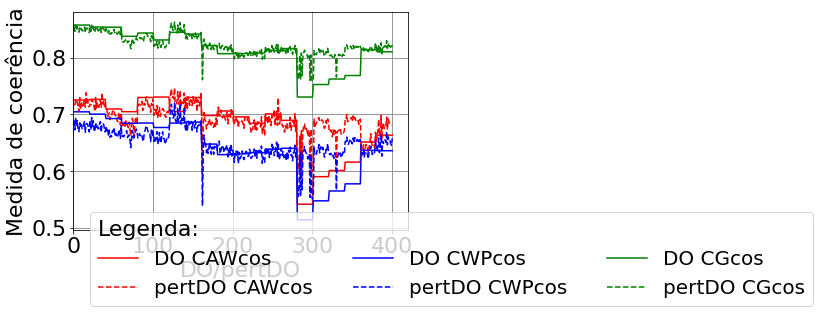

In [ ]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_CcosCAW, 
                   lista_perturbado_CcosCAW, 
                   lista_original_CcosCWP, 
                   lista_perturbado_CcosCWP, 
                   lista_original_CcosCG, 
                   lista_perturbado_CcosCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCAW, lista_perturbado_CcosCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCWP, lista_perturbado_CcosCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CcosCG, lista_perturbado_CcosCG))

Diferença entre as equação CAW      : 10.943162176126467
Diferença entre as equação CWP      : 10.748149994180768
Diferença entre as equação CG       : 6.069195584997002


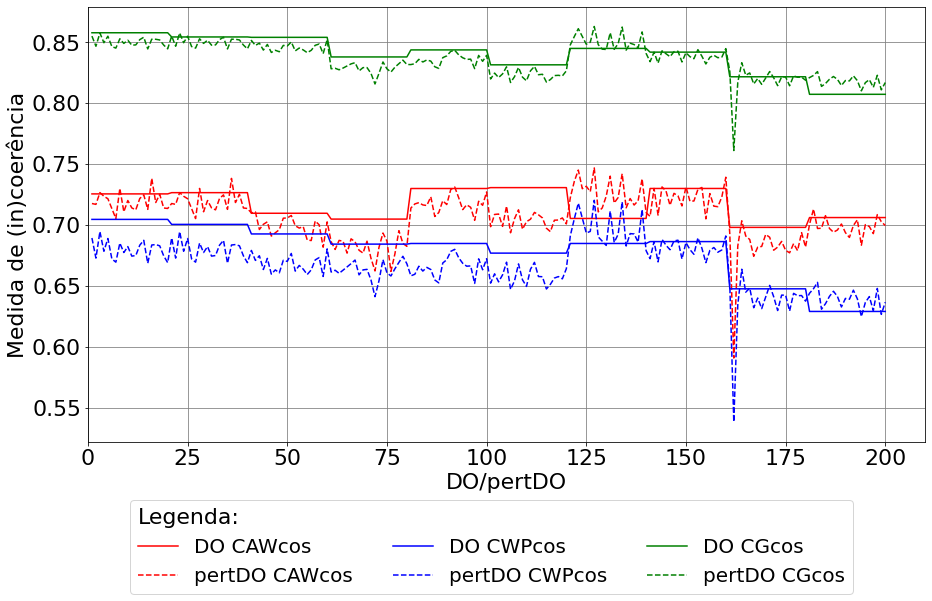

In [ ]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:200], 
                   lista_perturbado_CcosCAW[0:200], 
                   lista_original_CcosCWP[0:200], 
                   lista_perturbado_CcosCWP[0:200], 
                   lista_original_CcosCG[0:200], 
                   lista_perturbado_CcosCG[0:200],
                   medida = medida)

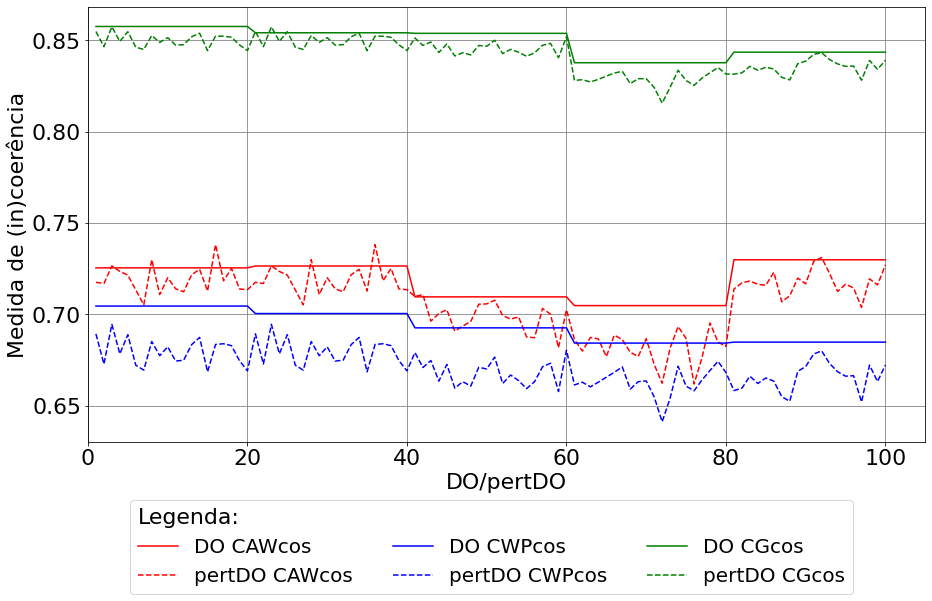

In [ ]:

graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:100], 
                   lista_perturbado_CcosCAW[0:100], 
                   lista_original_CcosCWP[0:100], 
                   lista_perturbado_CcosCWP[0:100], 
                   lista_original_CcosCG[0:100], 
                   lista_perturbado_CcosCG[0:100],
                  medida = medida)

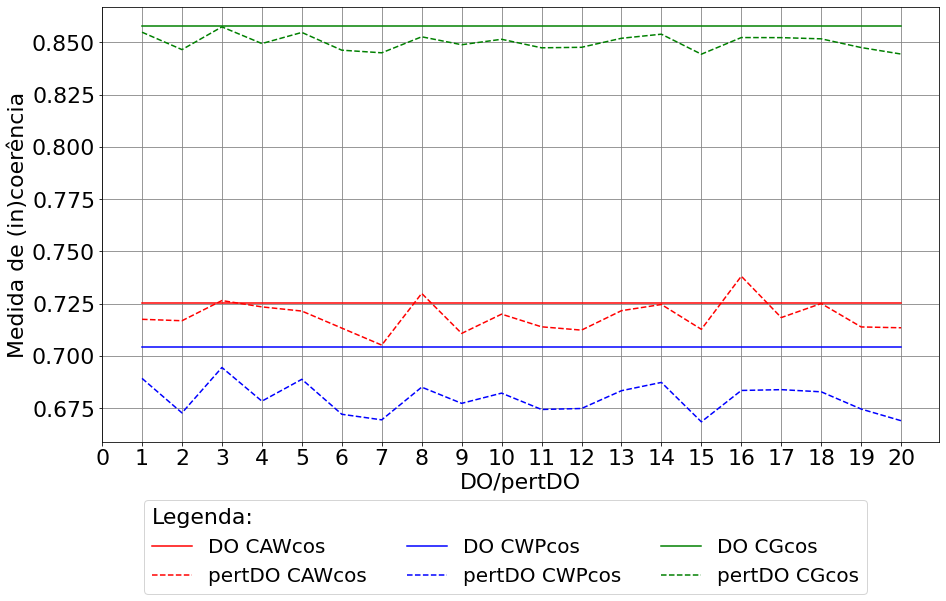

In [ ]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:20], 
                   lista_perturbado_CcosCAW[0:20], 
                   lista_original_CcosCWP[0:20], 
                   lista_perturbado_CcosCWP[0:20], 
                   lista_original_CcosCG[0:20], 
                   lista_perturbado_CcosCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

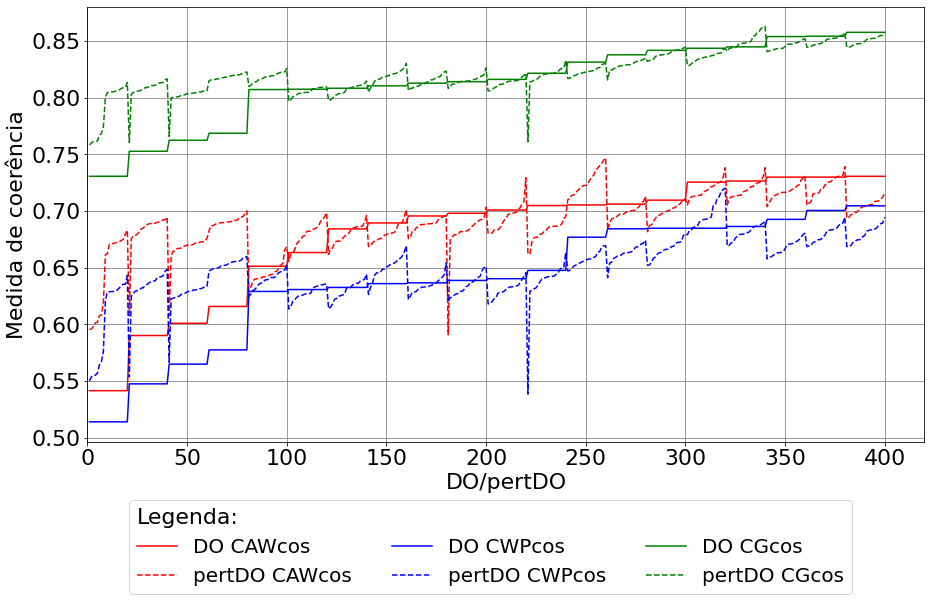

In [ ]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW, 
                   lista_perturbado_ordenado_CcosCAW, 
                   lista_original_ordenado_CcosCWP, 
                   lista_perturbado_ordenado_CcosCWP, 
                   lista_original_ordenado_CcosCG, 
                   lista_perturbado_ordenado_CcosCG,
                   medida = medida)

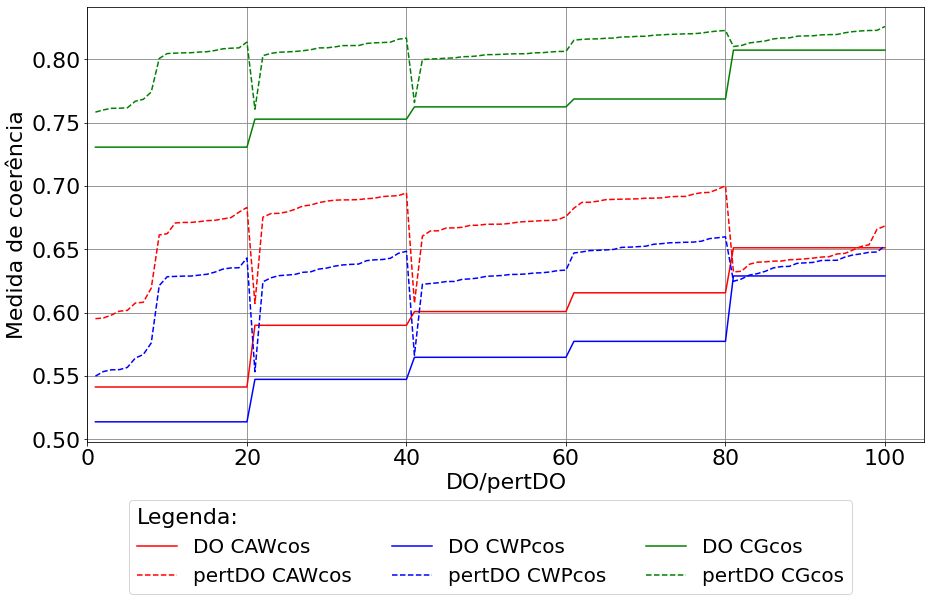

In [ ]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW[0:100], 
                   lista_perturbado_ordenado_CcosCAW[0:100], 
                   lista_original_ordenado_CcosCWP[0:100], 
                   lista_perturbado_ordenado_CcosCWP[0:100], 
                   lista_original_ordenado_CcosCG[0:100], 
                   lista_perturbado_ordenado_CcosCG[0:100],
                  medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

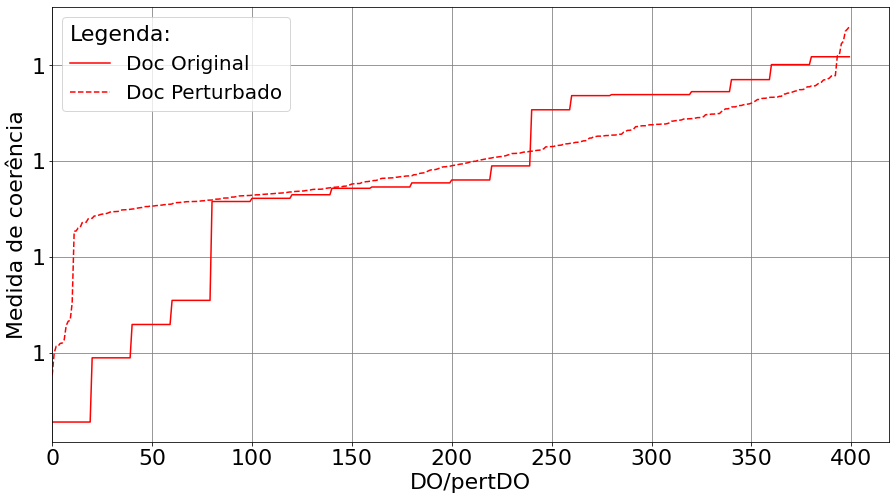

In [ ]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_ordenado_CcosCWP, 
                    lista_perturbado_ordenado_CcosCWP,
                    medida = 'cos')

Sem ordem

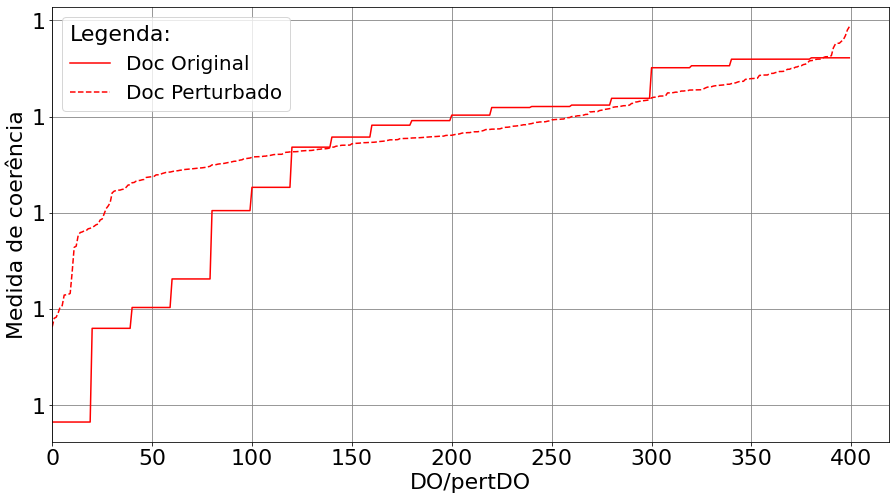

In [ ]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_CcosCAW, 
                    lista_perturbado_CcosCAW)

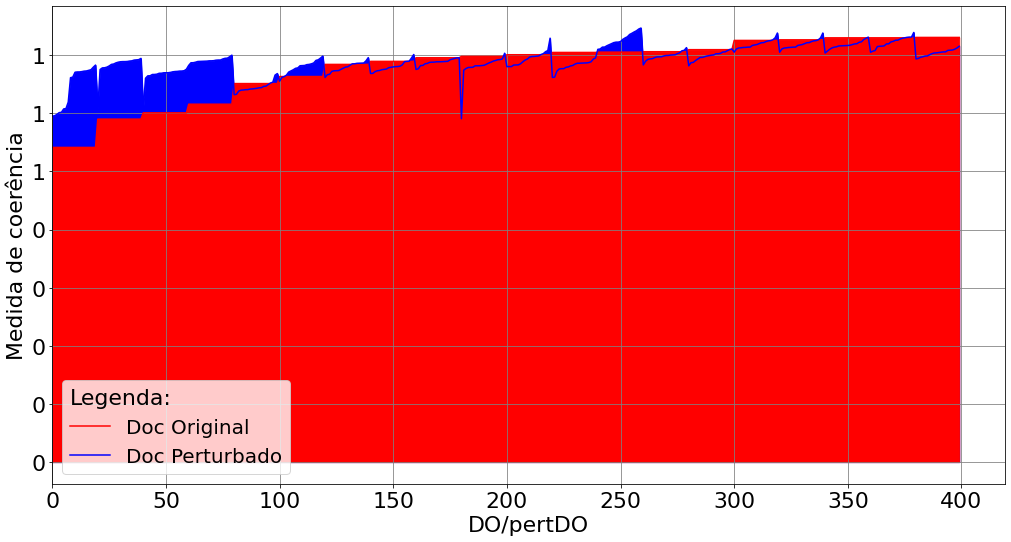

In [ ]:
graficoLinhaMedida2Preenchido('Medida de coerência', 
                              lista_original_ordenado_CcosCAW, 
                              lista_perturbado_ordenado_CcosCAW,
                              medida = 'cos')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 10.943162176126467

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['12', 0.15503664450211985, 7, 'O que é uma pilha e como desempilhar um elemento nela?']
['11', 0.1554512815041975, 9, 'O que é uma fila e como desenfileirar um elemento nela?']
['1', 0.16588834921518902, 16, 'Como enfileirar elementos em uma fila?']
['10', 0.1667712211608885, 14, 'O que é uma fila e como enfileirar seu elemento?']
['2', 0.1802255709966023, 17, 'Como desenfileirar elementos em uma fila?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 0.5363169041546902, 20, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['17', 1.308721792239409, 3, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['18', 1.5050414204597464, 4, 'C

##### Usando CAW onde Cm(pertDO)>Cm(DO) *


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 7.669909441659824

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 1.478737050841783e-05, 9, 'O que é uma fila e como desenfileirar um elemento nela?']
['5', 0.0012557506561279297, 18, 'Como empilhar elementos em uma estrutura de dados pilha?']
['3', 0.0014421741167705004, 15, 'Como empilhar elementos em uma pilha?']
['9', 0.005408382415771462, 10, 'O que é uma pilha e como empilhar seu elemento?']
['10', 0.010955148935317904, 14, 'O que é uma fila e como enfileirar seu elemento?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.4230667253335324, 13, 'Como desempilhar elementos em uma pilha?']
['17', 1.308721792239409, 3, 'Como são im

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma pilha e como transportar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> transportar(>CAWcos(pertDO)=0,5952460716)] - VERB/VERB-1-0
  2 - O que é uma pilha e como preparar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> preparar(>CAWcos(pertDO)=0,5957867565)] - VERB/VERB-1-0
  3 - O que é uma pilha e como ligar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> ligar(>CAWcos(pertDO)=0,5980688334)] - VERB/VERB-1-0
  4 - O que é uma pilha e como localizar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> localizar(>CAWcos(pertDO)=0,6011415372)] - VERB/VERB-1-0
  5 - O que é uma pilha e como organizar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> organizar(>CAWcos(pertDO)=0,6017641810)] - VERB/VERB-1-0
  6 - O que é uma pilha

In [ ]:
visualizaMedidasEquacoesCSV("13",
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 13
DO: O que é uma fila e como enfileirar um elemento nela?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
13_pert_0;O que é uma fila e como colocar um elemento nela ?;enfileirar;VERB;0,7007770322;0,6386518501;0,8127478311;colocar;VERB;0,6983051896;0,6412507783;0,8181503763;0,2825033963;0;1
13_pert_1;O que é uma fila e como adicionar um elemento nela ?;enfileirar;VERB;0,7007770322;0,6386518501;0,8127478311;adicionar;VERB;0,6886063435;0,6289771976;0,8112919877;0,0976047665;0;1
13_pert_2;O que é uma fila e como identificar um elemento nela ?;enfileirar;VERB;0,7007770322;0,6386518501;0,8127478311;identificar;VERB;0,6967030276;0,6369247897;0,8157037447;0,0576760769;0;1
13_pert_3;O que é uma fila e como incluir um elemento nela ?;enfileirar;VERB;0,7007770322;0,6386518501;0,8127478311;i

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 3.273252734466631

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.009440053593028686, 6, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['12', 0.12653904069553767, 7, 'O que é uma pilha e como desempilhar um elemento nela?']
['1', 0.1476150453090661, 16, 'Como enfileirar elementos em uma fila?']
['19', 0.15470537272366558, 5, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.1554364941336891, 9, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.21572868029276515, 15, 'Como empilhar elementos em uma pilha?']
['5', 0.24820099936591

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 20
DO: Em uma fila a operação de enfileirar ocorre em qual extremidade?
     ADP DET NOUN DET NOUN SCONJ VERB VERB ADP PRON NOUN PUNCT 
  1 - Em uma fila a operação de enfileirar inicia em qual extremidade ? [ocorre(>CAWcos(DO)=0,6632681272) -> inicia(CAWcos(pertDO)=0,6552494927)] - VERB/VERB-1-0
  2 - Em uma fila a operação de enfileirar começa em qual extremidade ? [ocorre(>CAWcos(DO)=0,6632681272) -> começa(CAWcos(pertDO)=0,6618467082)] - VERB/VERB-1-0
  3 - Em uma fila a operação de enfileirar ocorre em qual extremidade ? [ocorre(>CAWcos(DO)=0,6632681272) -> ocorre(CAWcos(pertDO)=0,6632681272)] - VERB/VERB-1-1
  4 - Em uma fila a operação de enfileirar termina em qual extremidade ? [ocorre(CAWcos(DO)=0,6632681272) -> termina(>CAWcos(pertDO)=0,6656640009)] - VERB/VERB-1-0
  5 - Em uma fila a operação de enfileirar acontece em qual extremidade ? [ocorre(CAWcos(DO)=0,6632681272) -> acontece(>CAWcos(pertDO)=0,6710164764)] - VERB/VERB-1-0
  6 - Em uma fila a operação de enfileira

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 20
DO: Em uma fila a operação de enfileirar ocorre em qual extremidade?
     ADP DET NOUN DET NOUN SCONJ VERB VERB ADP PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
20_pert_0;Em uma fila a operação de enfileirar ocorre em qual extremidade ?;ocorre;VERB;0,6632681272;0,6358252719;0,8104348481;ocorre;VERB;0,6632681272;0,6358252719;0,8104348481;0,3389283419;1;1
20_pert_1;Em uma fila a operação de enfileirar acontece em qual extremidade ?;ocorre;VERB;0,6632681272;0,6358252719;0,8104348481;acontece;VERB;0,6710164764;0,6429130020;0,8144628008;0,1639580280;0;1
20_pert_2;Em uma fila a operação de enfileirar é em qual extremidade ?;ocorre;VERB;0,6632681272;0,6358252719;0,8104348481;é;AUX;0,6910492073;0,6582265505;0,8234948019;0,0731816813;0;0
20_pert_3;Em uma fila a operação de enfileirar começa em qual extremidade ?;ocorre;VERB;0,6632

#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 10.748149994180768

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.11437258891987057, 9, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.11710214750333225, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['8', 0.1339196867412994, 17, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['12', 0.14358905725406879, 7, 'O que é uma pilha e como desempilhar um elemento nela?']
['13', 0.16648171526012967, 10, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 0.4983550281751732, 20, 'Como enfileirar elementos em uma fila?']
['17', 1.2088897187303702, 3, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['18', 1.51

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 7.139900619722139

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.007526677214738209, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['8', 0.011190797222985216, 17, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['9', 0.022607923637736893, 12, 'O que é uma pilha e como empilhar seu elemento?']
['11', 0.027810473333705232, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['19', 0.034954508145650376, 9, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['20', 0.2943092534939452, 8, 'Em uma fila a operação de enfileirar ocorre em qual 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma pilha e como localizar e desempilhar seus elementos ? [empilhar(CWPcos(DO)=0,5138434535) -> localizar(>CWPcos(pertDO)=0,5499159692)] - VERB/VERB-1-0
  2 - O que é uma pilha e como transportar e desempilhar seus elementos ? [empilhar(CWPcos(DO)=0,5138434535) -> transportar(>CWPcos(pertDO)=0,5535140785)] - VERB/VERB-1-0
  3 - O que é uma pilha e como preparar e desempilhar seus elementos ? [empilhar(CWPcos(DO)=0,5138434535) -> preparar(>CWPcos(pertDO)=0,5548881334)] - VERB/VERB-1-0
  4 - O que é uma pilha e como organizar e desempilhar seus elementos ? [empilhar(CWPcos(DO)=0,5138434535) -> organizar(>CWPcos(pertDO)=0,5550313118)] - VERB/VERB-1-0
  5 - O que é uma pilha e como ligar e desempilhar seus elementos ? [empilhar(CWPcos(DO)=0,5138434535) -> ligar(>CWPcos(pertDO)=0,5567399164)] - VERB/VERB-1-0
  6 - O que é uma pilha

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma pilha e como separar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;separar;VERB;0,6193286404;0,5760713367;0,7741510616;0,2085772902;0;1
15_pert_1;O que é uma pilha e como organizar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;organizar;VERB;0,6017641810;0,5550313118;0,7612817746;0,1126435548;0;1
15_pert_2;O que é uma pilha e como juntar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;juntar;VERB;0,6081554269;0,5641514036;0,7668200525;0,0891613439;0;1
15_pert_3;O que é uma pilha e como carregar e desempilhar seus elementos ?;em

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 3.6082493744586284

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 0.006628319350155842, 5, 'O que é uma fila e como enfileirar seu elemento?']
['7', 0.009537932418641759, 16, 'Como desempilhar elementos em uma pilha?']
['20', 0.013001377383867863, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['19', 0.07941808077422019, 9, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.08929167416962702, 6, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 0.38906771396145734, 13, 'Como empilhar e desempilhar elementos em uma estrutura de 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 10
DO: O que é uma fila e como enfileirar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
  1 - O que é uma fila e como calcular seu elemento ? [enfileirar(>CWPcos(DO)=0,6289414899) -> calcular(CWPcos(pertDO)=0,6247048936)] - VERB/VERB-1-0
  2 - O que é uma fila e como ocorre seu elemento ? [enfileirar(>CWPcos(DO)=0,6289414899) -> ocorre(CWPcos(pertDO)=0,6265497668)] - VERB/VERB-1-0
  3 - O que é uma fila e como surgiu seu elemento ? [enfileirar(CWPcos(DO)=0,6289414899) -> surgiu(>CWPcos(pertDO)=0,6296336418)] - VERB/VERB-1-0
  4 - O que é uma fila e como localizar seu elemento ? [enfileirar(CWPcos(DO)=0,6289414899) -> localizar(>CWPcos(pertDO)=0,6307812707)] - VERB/VERB-1-0
  5 - O que é uma fila e como funciona seu elemento ? [enfileirar(CWPcos(DO)=0,6289414899) -> funciona(>CWPcos(pertDO)=0,6326252005)] - VERB/VERB-1-0
  6 - O que é uma fila e como organizar seu elemento ? [enfileirar(CWPcos(DO)=0,6289414899) -> organizar(>CWPcos(pertDO)=0,6353011982)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 10
DO: O que é uma fila e como enfileirar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
10_pert_0;O que é uma fila e como identificar seu elemento ?;enfileirar;VERB;0,7059947550;0,6289414899;0,8071376627;identificar;VERB;0,7004899383;0,6439008529;0,8208629381;0,4559765458;0;1
10_pert_1;O que é uma fila e como é seu elemento ?;enfileirar;VERB;0,7059947550;0,6289414899;0,8071376627;é;AUX;0,7129894555;0,6476144677;0,8226178614;0,0366640650;0;0
10_pert_2;O que é uma fila e como definir seu elemento ?;enfileirar;VERB;0,7059947550;0,6289414899;0,8071376627;definir;VERB;0,6970243931;0,6528065958;0,8257973357;0,0358846597;0;1
10_pert_3;O que é uma fila e como localizar seu elemento ?;enfileirar;VERB;0,7059947550;0,6289414899;0,8071376627;localizar;VERB;0,6972285569;0,6307812707;

#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 6.069195584997002

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.056894650061924734, 10, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.06871008872985818, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['8', 0.07509490251541084, 15, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['12', 0.0838958422342937, 7, 'O que é uma pilha e como desempilhar um elemento nela?']
['14', 0.08398448427518213, 11, 'O que é uma pilha e como empilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['10', 0.21735463359139284, 5, 'O que é uma fila e como enfileirar seu elemento?']
['17', 0.7786612510681162, 3, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 4.73804329681349

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['2', 0.0045676742281232086, 19, 'Como desenfileirar elementos em uma fila?']
['8', 0.00708072185516373, 15, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.010634591182073216, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['14', 0.011629020174344418, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['12', 0.022974396745363945, 7, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['10', 0.21735463359139284, 5, 'O que é uma fila e como enfileirar seu elemento?']
['17', 0.778661251

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma pilha e como localizar e desempilhar seus elementos ? [empilhar(CGcos(DO)=0,7305820195) -> localizar(>CGcos(pertDO)=0,7582096778)] - VERB/VERB-1-0
  2 - O que é uma pilha e como transportar e desempilhar seus elementos ? [empilhar(CGcos(DO)=0,7305820195) -> transportar(>CGcos(pertDO)=0,7599802636)] - VERB/VERB-1-0
  3 - O que é uma pilha e como preparar e desempilhar seus elementos ? [empilhar(CGcos(DO)=0,7305820195) -> preparar(>CGcos(pertDO)=0,7612199967)] - VERB/VERB-1-0
  4 - O que é uma pilha e como organizar e desempilhar seus elementos ? [empilhar(CGcos(DO)=0,7305820195) -> organizar(>CGcos(pertDO)=0,7612817746)] - VERB/VERB-1-0
  5 - O que é uma pilha e como ligar e desempilhar seus elementos ? [empilhar(CGcos(DO)=0,7305820195) -> ligar(>CGcos(pertDO)=0,7616179448)] - VERB/VERB-1-0
  6 - O que é uma pilha e como ju

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma pilha e como separar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;separar;VERB;0,6193286404;0,5760713367;0,7741510616;0,2085772902;0;1
15_pert_1;O que é uma pilha e como organizar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;organizar;VERB;0,6017641810;0,5550313118;0,7612817746;0,1126435548;0;1
15_pert_2;O que é uma pilha e como juntar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;juntar;VERB;0,6081554269;0,5641514036;0,7668200525;0,0891613439;0;1
15_pert_3;O que é uma pilha e como carregar e desempilhar seus elementos ?;em

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 1.331152288183505

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.007626493771870968, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['7', 0.007700409208025394, 17, 'Como desempilhar elementos em uma pilha?']
['19', 0.017010216911633957, 10, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['13', 0.028247485558191565, 9, 'O que é uma fila e como enfileirar um elemento nela?']
['11', 0.05807549754778496, 6, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 0.15135637351444808, 20, 'Como enfileirar elementos em uma fila?']
['5', 0.159923

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 20
DO: Em uma fila a operação de enfileirar ocorre em qual extremidade?
     ADP DET NOUN DET NOUN SCONJ VERB VERB ADP PRON NOUN PUNCT 
  1 - Em uma fila a operação de enfileirar inicia em qual extremidade ? [ocorre(>CGcos(DO)=0,8104348481) -> inicia(CGcos(pertDO)=0,8048503945)] - VERB/VERB-1-0
  2 - Em uma fila a operação de enfileirar começa em qual extremidade ? [ocorre(>CGcos(DO)=0,8104348481) -> começa(CGcos(pertDO)=0,8083928078)] - VERB/VERB-1-0
  3 - Em uma fila a operação de enfileirar ocorre em qual extremidade ? [ocorre(>CGcos(DO)=0,8104348481) -> ocorre(CGcos(pertDO)=0,8104348481)] - VERB/VERB-1-1
  4 - Em uma fila a operação de enfileirar acontece em qual extremidade ? [ocorre(CGcos(DO)=0,8104348481) -> acontece(>CGcos(pertDO)=0,8144628008)] - VERB/VERB-1-0
  5 - Em uma fila a operação de enfileirar termina em qual extremidade ? [ocorre(CGcos(DO)=0,8104348481) -> termina(>CGcos(pertDO)=0,8158266544)] - VERB/VERB-1-0
  6 - Em uma fila a operação de enfileirar surge em

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 20
DO: Em uma fila a operação de enfileirar ocorre em qual extremidade?
     ADP DET NOUN DET NOUN SCONJ VERB VERB ADP PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
20_pert_0;Em uma fila a operação de enfileirar ocorre em qual extremidade ?;ocorre;VERB;0,6632681272;0,6358252719;0,8104348481;ocorre;VERB;0,6632681272;0,6358252719;0,8104348481;0,3389283419;1;1
20_pert_1;Em uma fila a operação de enfileirar acontece em qual extremidade ?;ocorre;VERB;0,6632681272;0,6358252719;0,8104348481;acontece;VERB;0,6710164764;0,6429130020;0,8144628008;0,1639580280;0;1
20_pert_2;Em uma fila a operação de enfileirar é em qual extremidade ?;ocorre;VERB;0,6632681272;0,6358252719;0,8104348481;é;AUX;0,6910492073;0,6582265505;0,8234948019;0,0731816813;0;0
20_pert_3;Em uma fila a operação de enfileirar começa em qual extremidade ?;ocorre;VERB;0,6632

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 1.331152288183505

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.01906942237507203, 5, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.02007923884825269, 9, 'O que é uma fila e como desenfileirar um elemento nela?']
['1', 0.02024322748184204, 16, 'Como enfileirar elementos em uma fila?']
['14', 0.020835898139260012, 8, 'O que é uma pilha e como empilhar um elemento nela?']
['2', 0.02126731475194299, 17, 'Como desenfileirar elementos em uma fila?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 0.07508183270692825, 3, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['18', 0.08444265333505774, 4, 'Como são implementadas as operações

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 1.331152288183505

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 1.478737050841783e-05, 9, 'O que é uma fila e como desenfileirar um elemento nela?']
['3', 0.0011925299962362024, 15, 'Como empilhar elementos em uma pilha?']
['5', 0.0012557506561279297, 18, 'Como empilhar elementos em uma estrutura de dados pilha?']
['9', 0.005408382415771462, 10, 'O que é uma pilha e como empilhar seu elemento?']
['10', 0.006994700431823708, 14, 'O que é uma fila e como enfileirar seu elemento?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.04146854082743334, 13, 'Como desempilhar elementos em uma pilha?']
['17', 0.07508183270692825, 3, 'Como são implement

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma pilha e como transportar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> transportar(>CAWcos(pertDO)=0,5952460716)] - VERB/VERB-1-0
  2 - O que é uma pilha e como preparar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> preparar(>CAWcos(pertDO)=0,5957867565)] - VERB/VERB-1-0
  3 - O que é uma pilha e como ligar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> ligar(>CAWcos(pertDO)=0,5980688334)] - VERB/VERB-1-0
  4 - O que é uma pilha e como localizar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> localizar(>CAWcos(pertDO)=0,6011415372)] - VERB/VERB-1-0
  5 - O que é uma pilha e como organizar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> organizar(>CAWcos(pertDO)=0,6017641810)] - VERB/VERB-1-0
  6 - O que é uma pilha

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma pilha e como separar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;separar;VERB;0,6193286404;0,5760713367;0,7741510616;0,2085772902;0;1
15_pert_1;O que é uma pilha e como organizar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;organizar;VERB;0,6017641810;0,5550313118;0,7612817746;0,1126435548;0;1
15_pert_2;O que é uma pilha e como juntar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;juntar;VERB;0,6081554269;0,5641514036;0,7668200525;0,0891613439;0;1
15_pert_3;O que é uma pilha e como carregar e desempilhar seus elementos ?;em

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 1.331152288183505

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.008018634536049563, 6, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['19', 0.01906942237507203, 5, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.02007923884825269, 9, 'O que é uma fila e como desenfileirar um elemento nela?']
['1', 0.02024322748184204, 16, 'Como enfileirar elementos em uma fila?']
['13', 0.020486197688362795, 11, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 0.026111894183688644, 18, 'Como empilhar elementos em uma estrutura de dados pilha?']
['3', 0.02

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9
DO: O que é uma pilha e como empilhar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
  1 - O que é uma pilha e como funciona seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> funciona(CAWcos(pertDO)=0,5907305241)] - VERB/VERB-1-0
  2 - O que é uma pilha e como calcular seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> calcular(CAWcos(pertDO)=0,6741981924)] - VERB/VERB-1-0
  3 - O que é uma pilha e como obter seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> obter(CAWcos(pertDO)=0,6770577967)] - VERB/VERB-1-0
  4 - O que é uma pilha e como determinar seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> determinar(CAWcos(pertDO)=0,6788599491)] - VERB/VERB-1-0
  5 - O que é uma pilha e como formar seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> formar(CAWcos(pertDO)=0,6790969729)] - VERB/VERB-1-0
  6 - O que é uma pilha e como descobrir seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> descobrir(CAWcos(pertDO)=0,6791856229)] - VERB

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9
DO: O que é uma pilha e como empilhar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
9_pert_0;O que é uma pilha e como identificar seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;identificar;VERB;0,6925180554;0,6506037913;0,8260237195;0,2645019293;0;1
9_pert_1;O que é uma pilha e como funciona seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;funciona;VERB;0,5907305241;0,5383625085;0,7609847242;0,1115467995;0;1
9_pert_2;O que é uma pilha e como localizar seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;localizar;VERB;0,6826296508;0,6341930817;0,8169250001;0,0455888063;0;1
9_pert_3;O que é uma pilha e como é seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;é;AUX;0,7033409595;0,6635855133;0,833065

#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 1.331152288183505

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 0.017187549760847354, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['8', 0.01725549300511675, 17, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['19', 0.017654172398827273, 9, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['13', 0.018571634184230468, 10, 'O que é uma fila e como enfileirar um elemento nela?']
['12', 0.018891926516186097, 7, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 0.06877723278907621, 3, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['18', 0.08248590530602495, 

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 1.331152288183505

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 0.004614457819196893, 17, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['11', 0.004739834052143621, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['14', 0.005474566058679131, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['12', 0.011773910937887266, 7, 'O que é uma pilha e como desempilhar um elemento nela?']
['13', 0.01230081599770172, 10, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.03544614144733971, 16, 'Como desempilhar elementos em uma pilha?']
['17', 0.0687772327890762

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma pilha e como transportar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> transportar(>CAWcos(pertDO)=0,5952460716)] - VERB/VERB-1-0
  2 - O que é uma pilha e como preparar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> preparar(>CAWcos(pertDO)=0,5957867565)] - VERB/VERB-1-0
  3 - O que é uma pilha e como ligar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> ligar(>CAWcos(pertDO)=0,5980688334)] - VERB/VERB-1-0
  4 - O que é uma pilha e como localizar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> localizar(>CAWcos(pertDO)=0,6011415372)] - VERB/VERB-1-0
  5 - O que é uma pilha e como organizar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> organizar(>CAWcos(pertDO)=0,6017641810)] - VERB/VERB-1-0
  6 - O que é uma pilha

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma pilha e como separar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;separar;VERB;0,6193286404;0,5760713367;0,7741510616;0,2085772902;0;1
15_pert_1;O que é uma pilha e como organizar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;organizar;VERB;0,6017641810;0,5550313118;0,7612817746;0,1126435548;0;1
15_pert_2;O que é uma pilha e como juntar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;juntar;VERB;0,6081554269;0,5641514036;0,7668200525;0,0891613439;0;1
15_pert_3;O que é uma pilha e como carregar e desempilhar seus elementos ?;em

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 1.331152288183505

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 0.0042365962808782465, 5, 'O que é uma fila e como enfileirar seu elemento?']
['7', 0.005859616256895572, 16, 'Como desempilhar elementos em uma pilha?']
['20', 0.009612929640394285, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['19', 0.01482284023906244, 9, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.017187549760847354, 6, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 0.03278465535905628, 15, 'Como empilhar elementos em uma estrutura de dados pilha?']
['3', 0.034

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9
DO: O que é uma pilha e como empilhar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
  1 - O que é uma pilha e como funciona seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> funciona(CAWcos(pertDO)=0,5907305241)] - VERB/VERB-1-0
  2 - O que é uma pilha e como calcular seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> calcular(CAWcos(pertDO)=0,6741981924)] - VERB/VERB-1-0
  3 - O que é uma pilha e como obter seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> obter(CAWcos(pertDO)=0,6770577967)] - VERB/VERB-1-0
  4 - O que é uma pilha e como determinar seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> determinar(CAWcos(pertDO)=0,6788599491)] - VERB/VERB-1-0
  5 - O que é uma pilha e como formar seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> formar(CAWcos(pertDO)=0,6790969729)] - VERB/VERB-1-0
  6 - O que é uma pilha e como descobrir seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> descobrir(CAWcos(pertDO)=0,6791856229)] - VERB

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9
DO: O que é uma pilha e como empilhar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
9_pert_0;O que é uma pilha e como identificar seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;identificar;VERB;0,6925180554;0,6506037913;0,8260237195;0,2645019293;0;1
9_pert_1;O que é uma pilha e como funciona seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;funciona;VERB;0,5907305241;0,5383625085;0,7609847242;0,1115467995;0;1
9_pert_2;O que é uma pilha e como localizar seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;localizar;VERB;0,6826296508;0,6341930817;0,8169250001;0,0455888063;0;1
9_pert_3;O que é uma pilha e como é seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;é;AUX;0,7033409595;0,6635855133;0,833065

#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 1.331152288183505

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 0.009722244739532426, 15, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['2', 0.00981361525399338, 19, 'Como desenfileirar elementos em uma fila?']
['14', 0.010214358568191528, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['11', 0.010586097836494446, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['13', 0.010685970385869381, 9, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 0.04374033106224884, 3, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['18', 0.05405160252537056, 4, 'Como são implementadas 

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 1.331152288183505

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 0.002090767025947571, 6, 'O que é uma fila e como desenfileirar um elemento nela?']
['8', 0.002891397476196378, 15, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['2', 0.0032613277435302734, 19, 'Como desenfileirar elementos em uma fila?']
['14', 0.005531534552574158, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['12', 0.0064254353443781165, 7, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['20', 0.01978481312592828, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['17', 0.043

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
  1 - O que é uma pilha e como transportar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> transportar(>CAWcos(pertDO)=0,5952460716)] - VERB/VERB-1-0
  2 - O que é uma pilha e como preparar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> preparar(>CAWcos(pertDO)=0,5957867565)] - VERB/VERB-1-0
  3 - O que é uma pilha e como ligar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> ligar(>CAWcos(pertDO)=0,5980688334)] - VERB/VERB-1-0
  4 - O que é uma pilha e como localizar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> localizar(>CAWcos(pertDO)=0,6011415372)] - VERB/VERB-1-0
  5 - O que é uma pilha e como organizar e desempilhar seus elementos ? [empilhar(CAWcos(DO)=0,5413257716) -> organizar(>CAWcos(pertDO)=0,6017641810)] - VERB/VERB-1-0
  6 - O que é uma pilha

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: O que é uma pilha e como empilhar e desempilhar seus elementos?
     PRON PRON AUX DET NOUN CCONJ ADV VERB CCONJ NOUN DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;O que é uma pilha e como separar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;separar;VERB;0,6193286404;0,5760713367;0,7741510616;0,2085772902;0;1
15_pert_1;O que é uma pilha e como organizar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;organizar;VERB;0,6017641810;0,5550313118;0,7612817746;0,1126435548;0;1
15_pert_2;O que é uma pilha e como juntar e desempilhar seus elementos ?;empilhar;VERB;0,5413257716;0,5138434535;0,7305820195;juntar;VERB;0,6081554269;0,5641514036;0,7668200525;0,0891613439;0;1
15_pert_3;O que é uma pilha e como carregar e desempilhar seus elementos ?;em

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 1.331152288183505

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.004066305501120415, 17, 'Como desempilhar elementos em uma pilha?']
['20', 0.005584453543027279, 8, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['19', 0.005956321954727173, 10, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['13', 0.006685962279637581, 9, 'O que é uma fila e como enfileirar um elemento nela?']
['8', 0.009722244739532426, 15, 'Como desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 0.013375725064958877, 18, 'Como empilhar elementos em uma pilha?']
['6', 0.01450227200984

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9
DO: O que é uma pilha e como empilhar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
  1 - O que é uma pilha e como funciona seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> funciona(CAWcos(pertDO)=0,5907305241)] - VERB/VERB-1-0
  2 - O que é uma pilha e como calcular seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> calcular(CAWcos(pertDO)=0,6741981924)] - VERB/VERB-1-0
  3 - O que é uma pilha e como obter seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> obter(CAWcos(pertDO)=0,6770577967)] - VERB/VERB-1-0
  4 - O que é uma pilha e como determinar seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> determinar(CAWcos(pertDO)=0,6788599491)] - VERB/VERB-1-0
  5 - O que é uma pilha e como formar seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> formar(CAWcos(pertDO)=0,6790969729)] - VERB/VERB-1-0
  6 - O que é uma pilha e como descobrir seu elemento ? [empilhar(>CAWcos(DO)=0,6979325771) -> descobrir(CAWcos(pertDO)=0,6791856229)] - VERB

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 9
DO: O que é uma pilha e como empilhar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
9_pert_0;O que é uma pilha e como identificar seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;identificar;VERB;0,6925180554;0,6506037913;0,8260237195;0,2645019293;0;1
9_pert_1;O que é uma pilha e como funciona seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;funciona;VERB;0,5907305241;0,5383625085;0,7609847242;0,1115467995;0;1
9_pert_2;O que é uma pilha e como localizar seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;localizar;VERB;0,6826296508;0,6341930817;0,8169250001;0,0455888063;0;1
9_pert_3;O que é uma pilha e como é seu elemento ?;empilhar;VERB;0,6979325771;0,6475148234;0,8215280609;é;AUX;0,7033409595;0,6635855133;0,833065

## 3.6  Avaliando o cálculo da incoerência com todas as equações e com a medida de distância euclidiana(euc)






In [ ]:
medida = 'euc'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 247 de 400
Percentual de documentos coerentes em relação ao total: 61.75000000000001
Acertos Perturbado : 153 de 400
Percentual de documentos incoerentes em relação ao total: 38.25


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 239 de 400
Percentual de documentos coerentes em relação ao total: 59.75
Acertos Perturbado : 161 de 400
Percentual de documentos incoerentes em relação ao total: 40.25


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 234 de 400
Percentual de documentos coerentes em relação ao total: 58.5
Acertos Perturbado : 166 de 400
Percentual de documentos incoerentes em relação ao total: 41.5


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;Como entrar elementos em uma fila ?
2;Como classificar elementos em uma fila ?
3;Como classificar elementos em uma pilha ?
4;Como ligar e desempilhar elementos em uma pilha ?
5;Como classificar elementos em uma estrutura de dados pilha ?
6;Como conter e desempilhar elementos em uma estrutura de dados pilha ?
7;Como desempilhar elementos em uma caixa ?
8;Como desempilhar elementos em uma banco de dados pilha ?
9;O que é uma pilha e como funciona seu elemento ?
10;O que é uma fila e como ocorre seu elemento ?
11;O que é uma fila e como desenfileirar um automóvel nela ?
12;O que é uma pilha e como desempilhar um disco nela ?
13;O que é uma fila e como cada um elemento nela ?
14;O que é uma pilha e como por um elemento nela ?
15;O que é uma pilha e como preparar e desempilhar seus elementos ?
16;O que é uma fila e como organizar e desenfileirar seus elementos ?
17;Como são implementadas as operações de colar e desempilhar elementos em uma pilha ?
18;Como são implementadas as operações de

### Gráficos

#### Gráfico de linha das medida de coerência Ceuc dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





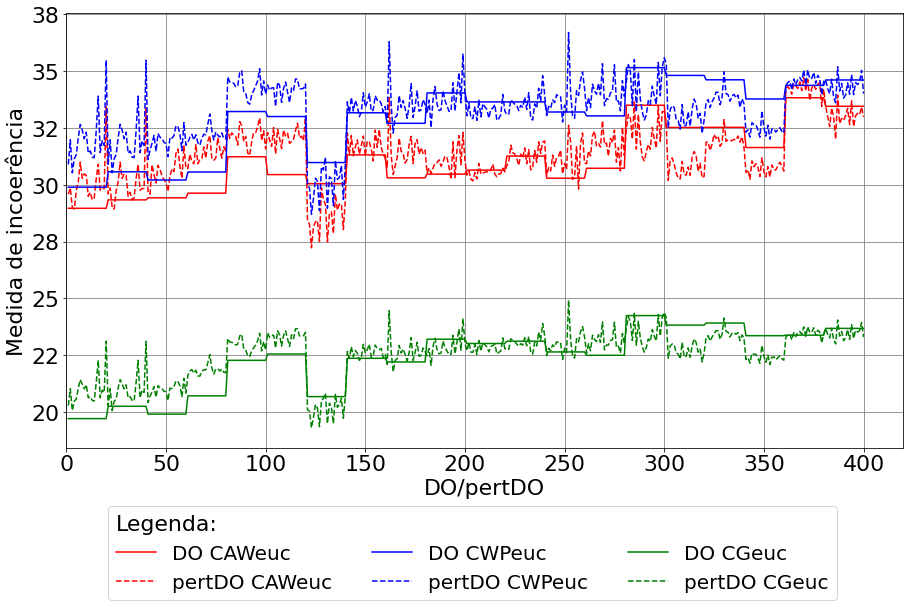

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW, 
                   lista_perturbado_CeucCAW, 
                   lista_original_CeucCWP, 
                   lista_perturbado_CeucCWP, 
                   lista_original_CeucCG, 
                   lista_perturbado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 377.5533389457181
Diferença absoluta entre as medidas equação CWP : 403.42198266249426
Diferença absoluta entre as medidas equação CG  : 256.61059489976907


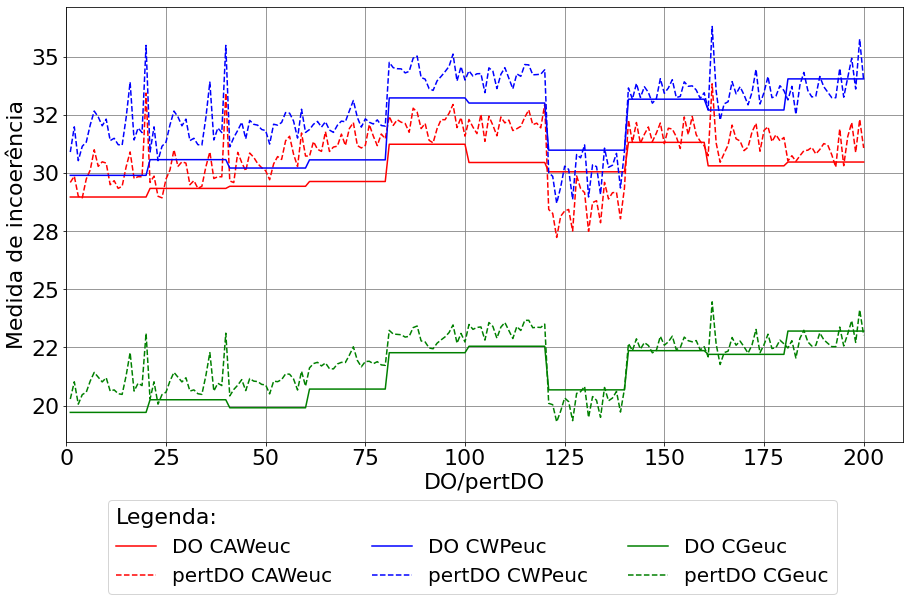

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW[0:200], 
                   lista_perturbado_CeucCAW[0:200], 
                   lista_original_CeucCWP[0:200], 
                   lista_perturbado_CeucCWP[0:200], 
                   lista_original_CeucCG[0:200], 
                   lista_perturbado_CeucCG[0:200],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

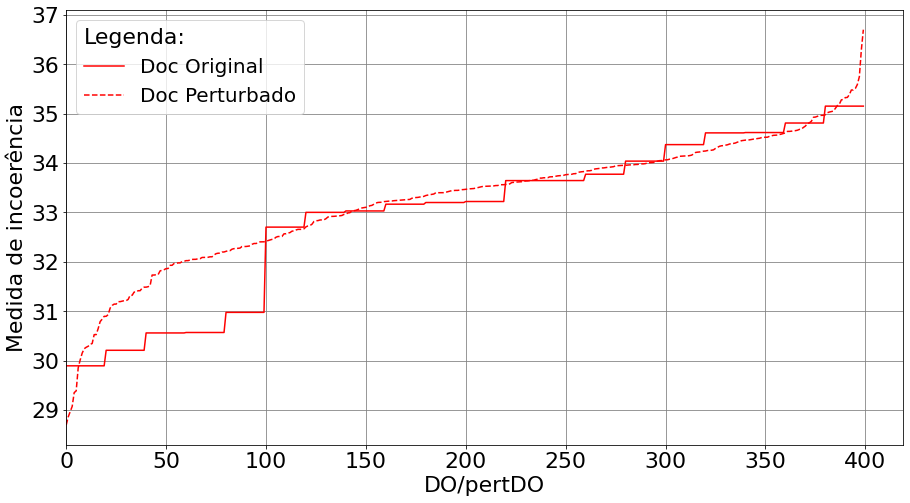

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCWP, 
                    lista_perturbado_CeucCWP,
                    'r',
                    medida = medida)

Sem ordem

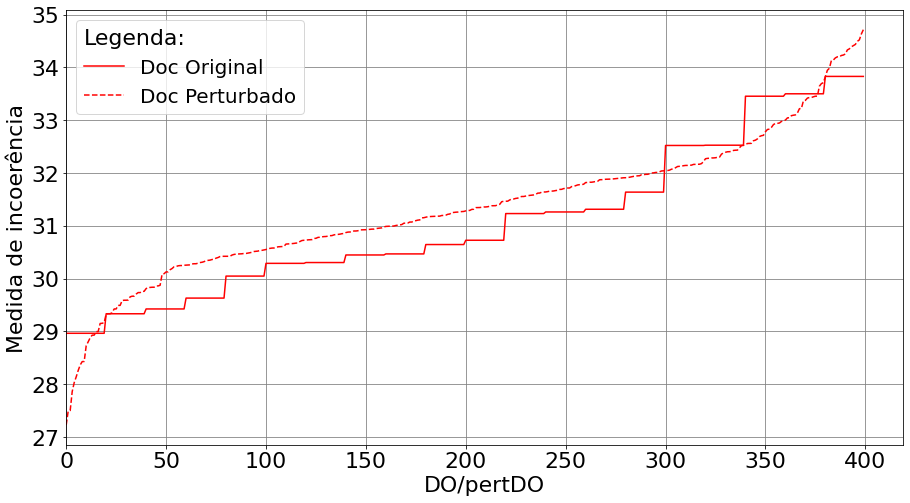

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCAW, 
                    lista_perturbado_CeucCAW,
                    'r',
                    medida = 'euc')

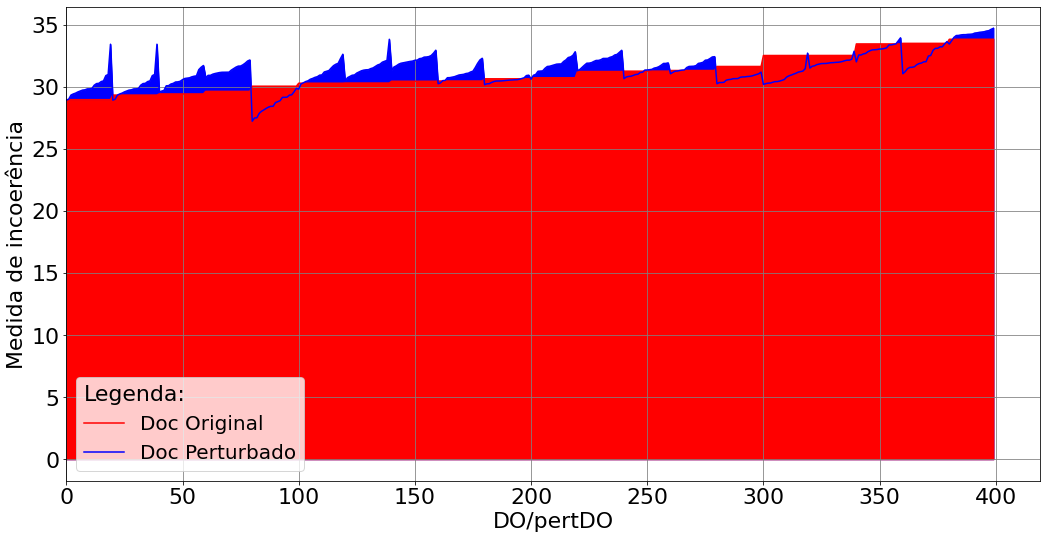

In [ ]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CeucCAW, 
                              lista_perturbado_ordenado_CeucCAW,
                              medida = 'euc')

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

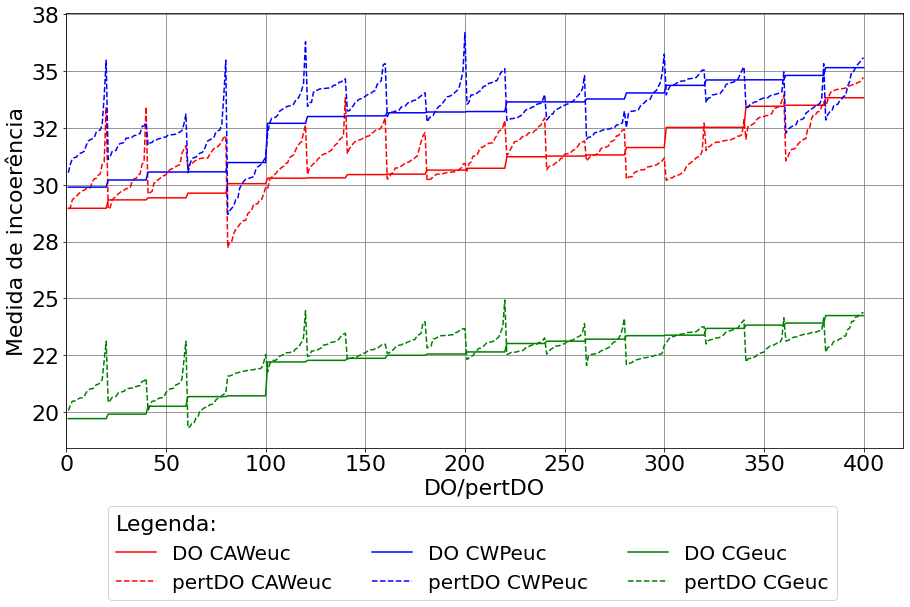

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW, 
                   lista_perturbado_ordenado_CeucCAW, 
                   lista_original_ordenado_CeucCWP, 
                   lista_perturbado_ordenado_CeucCWP, 
                   lista_original_ordenado_CeucCG, 
                   lista_perturbado_ordenado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 377.5533389457181
Diferença absoluta entre as medidas equação CWP : 403.42198266249426
Diferença absoluta entre as medidas equação CG  : 256.61059489976907


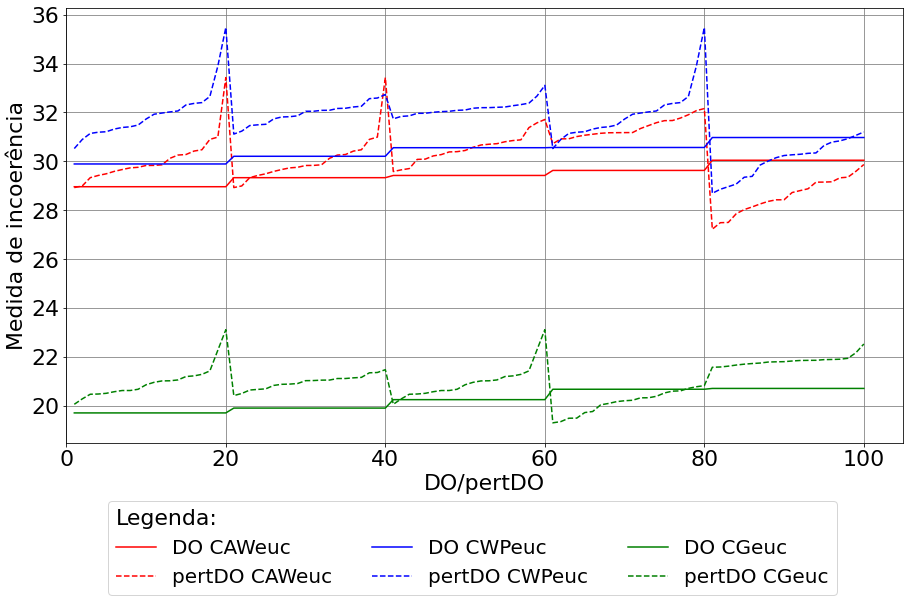

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[0:100], 
                   lista_perturbado_ordenado_CeucCAW[0:100], 
                   lista_original_ordenado_CeucCWP[0:100], 
                   lista_perturbado_ordenado_CeucCWP[0:100], 
                   lista_original_ordenado_CeucCG[0:100], 
                   lista_perturbado_ordenado_CeucCG[0:100],
                   medida = medida)

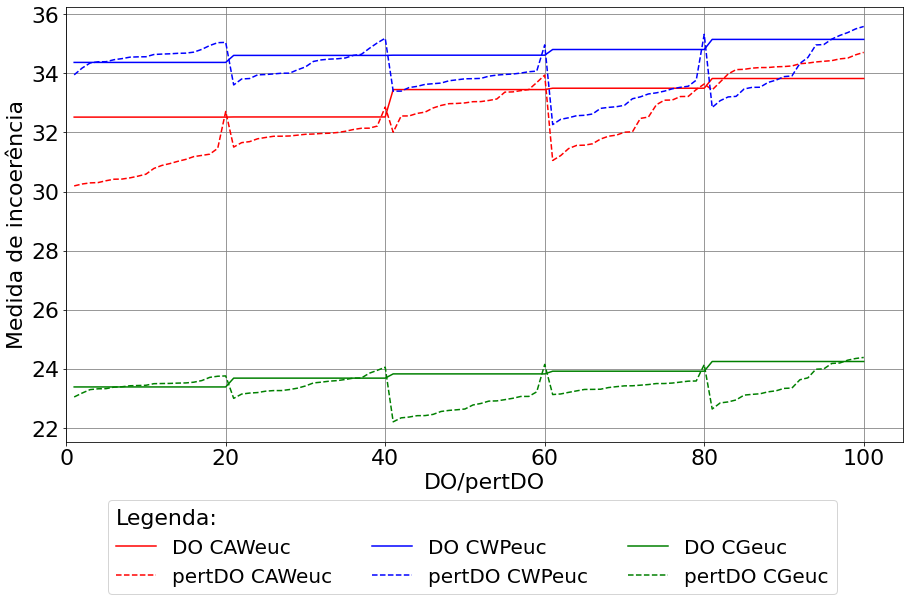

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

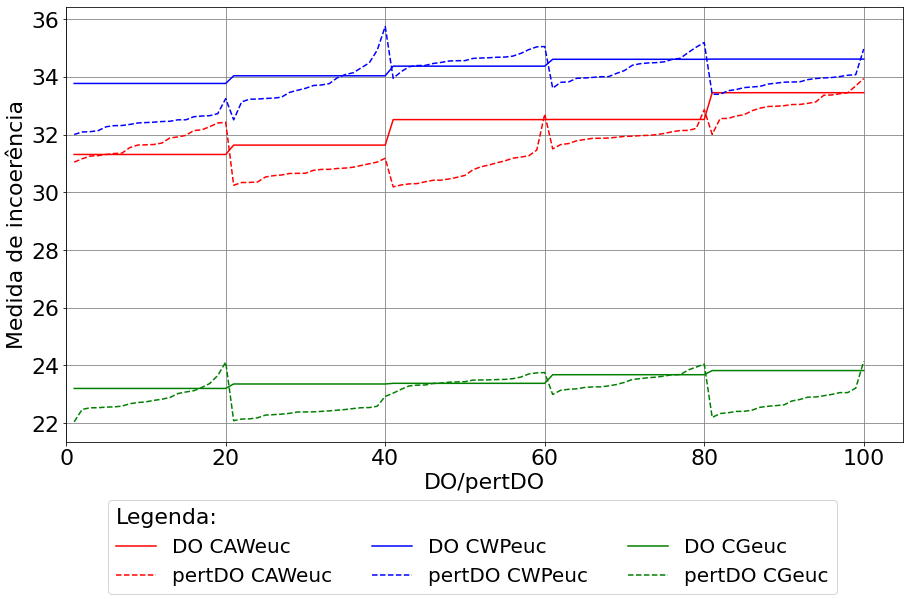

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[260:360], 
                   lista_perturbado_ordenado_CeucCAW[260:360], 
                   lista_original_ordenado_CeucCWP[260:360], 
                   lista_perturbado_ordenado_CeucCWP[260:360], 
                   lista_original_ordenado_CeucCG[260:360], 
                   lista_perturbado_ordenado_CeucCG[260:360],
                   medida = medida)

# DO central do gráfico com a maior diferença
# idDO = 16 
# difabs= 34.21611531575515, 
# O que é uma fila e como enfileirar e desenfileirar seus elementos?
# Posição gráfico 16 * 20 = 320

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 377.5533389457181

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 3.750918128273696, 10, 'O que é uma fila e como desenfileirar um elemento nela?']
['12', 6.69590429826216, 13, 'O que é uma pilha e como desempilhar um elemento nela?']
['8', 8.929655287000873, 14, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['19', 9.405750274658253, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['20', 9.797900286587819, 18, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15', 24.535284837086998, 19, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['7', 29.192986170450848, 5, 'Como desempilhar elementos em uma pilha?']
['6', 33.684496446089426, 8, '

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 241.5549477119642

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 0.1436452865600586, 19, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['16', 0.19209575653076172, 16, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['17', 0.3373527526855469, 17, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['11', 0.6562454917214176, 10, 'O que é uma fila e como desenfileirar um elemento nela?']
['20', 0.7298393249511719, 18, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 22.102965672810896, 1, 'Com

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: Como empilhar e desempilhar elementos em uma pilha?
     SCONJ VERB CCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como separar e desempilhar elementos em uma pilha ? [empilhar(>CAWeuc(DO)=29,6294147968) -> separar(CAWeuc(pertDO)=30,7197577953)] - VERB/VERB-1-0
  2 - Como cortar e desempilhar elementos em uma pilha ? [empilhar(>CAWeuc(DO)=29,6294147968) -> cortar(CAWeuc(pertDO)=30,9211232662)] - VERB/VERB-1-0
  3 - Como juntar e desempilhar elementos em uma pilha ? [empilhar(>CAWeuc(DO)=29,6294147968) -> juntar(CAWeuc(pertDO)=30,9233417511)] - VERB/VERB-1-0
  4 - Como colocar e desempilhar elementos em uma pilha ? [empilhar(>CAWeuc(DO)=29,6294147968) -> colocar(CAWeuc(pertDO)=31,0148460865)] - VERB/VERB-1-0
  5 - Como pegar e desempilhar elementos em uma pilha ? [empilhar(>CAWeuc(DO)=29,6294147968) -> pegar(CAWeuc(pertDO)=31,0694813728)] - VERB/VERB-1-0
  6 - Como organizar e desempilhar elementos em uma pilha ? [empilhar(>CAWeuc(DO)=29,6294147968) -> organizar(CAWeuc(pertDO)=3

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: Como empilhar e desempilhar elementos em uma pilha?
     SCONJ VERB CCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
4_pert_0;Como separar e desempilhar elementos em uma pilha ?;empilhar;VERB;29,6294147968;30,5592450036;20,7094741397;separar;VERB;30,7197577953;31,8613515960;21,6201860640;0,1631366313;0;1
4_pert_1;Como introduzir e desempilhar elementos em uma pilha ?;empilhar;VERB;29,6294147968;30,5592450036;20,7094741397;introduzir;VERB;31,3445012569;32,0892954402;21,8044455846;0,0901386663;0;1
4_pert_2;Como colocar e desempilhar elementos em uma pilha ?;empilhar;VERB;29,6294147968;30,5592450036;20,7094741397;colocar;VERB;31,0148460865;32,2121922175;21,8602513207;0,0658044368;0;1
4_pert_3;Como juntar e desempilhar elementos em uma pilha ?;empilhar;VERB;29,6294147968;30,5592450036;20,7094741397;juntar;VE

##### Usando CAW onde Cm(pertDO)<Cm(DO) *

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 135.99839123375398

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['1', 0.035093625386554805, 1, 'Como enfileirar elementos em uma fila?']
['14', 0.12159434231844557, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['10', 0.3780467987060483, 9, 'O que é uma fila e como enfileirar seu elemento?']
['19', 0.5039232427423599, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['8', 0.5116255018446161, 14, 'Como desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 11.511005548330466, 17, 'Como são implementadas as operações de empilhar e desempilhar elementos em u

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
# id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
  1 - O que é uma fila e como separar e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> separar(>CAWeuc(pertDO)=30,1893971761)] - VERB/VERB-1-0
  2 - O que é uma fila e como montar e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> montar(>CAWeuc(pertDO)=30,2542613347)] - VERB/VERB-1-0
  3 - O que é uma fila e como retirar e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> retirar(>CAWeuc(pertDO)=30,2919403712)] - VERB/VERB-1-0
  4 - O que é uma fila e como construir e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> construir(>CAWeuc(pertDO)=30,3023366928)] - VERB/VERB-1-0
  5 - O que é uma fila e como remover e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> remover(>CAWeuc(pertDO)=30,3650172551)] - VERB/VERB-1-0
  6 - 

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
16_pert_0;O que é uma fila e como organizar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;organizar;VERB;32,7120091120;35,3248745845;24,1437998552;0,2538270056;0;1
16_pert_1;O que é uma fila e como separar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;separar;VERB;30,1893971761;32,4975694265;22,3601920788;0,1979819685;0;1
16_pert_2;O que é uma fila e como juntar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;juntar;VERB;31,0885009766;33,3037643922;22,9003741925;0,1565645039;0;1
16_pert_3;O que é uma fila e como reunir e des

#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 403.42198266249426

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 5.627771348664119, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['12', 7.129173192110926, 13, 'O que é uma pilha e como desempilhar um elemento nela?']
['8', 7.476228374905091, 9, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['20', 8.561494104789936, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['11', 8.740490566600428, 12, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 28.14223434811551, 4, 'Como desenfileirar elementos em uma fila?']
['4', 32.23898686303034, 3, 'Como empilhar e desempilhar elementos em uma pilha?']
['16', 34.7252017779228, 19, 'O que é uma

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 256.4625084657676

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.3149406796409906, 5, 'Como desempilhar elementos em uma pilha?']
['17', 0.34954959743625125, 18, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['11', 0.40553402178215237, 12, 'O que é uma fila e como desenfileirar um elemento nela?']
['16', 0.5148772582029721, 19, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['15', 1.1714309545663752, 20, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 24.243842905217953, 7, 'Como empilhar e desempilh

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como encontrar elementos em uma fila ? [enfileirar(>CWPeuc(DO)=29,8935899280) -> encontrar(CWPeuc(pertDO)=30,5253366743)] - VERB/VERB-1-0
  2 - Como colocar elementos em uma fila ? [enfileirar(>CWPeuc(DO)=29,8935899280) -> colocar(CWPeuc(pertDO)=30,8959022704)] - VERB/VERB-1-0
  3 - Como adicionar elementos em uma fila ? [enfileirar(>CWPeuc(DO)=29,8935899280) -> adicionar(CWPeuc(pertDO)=31,1433072771)] - VERB/VERB-1-0
  4 - Como procurar elementos em uma fila ? [enfileirar(>CWPeuc(DO)=29,8935899280) -> procurar(CWPeuc(pertDO)=31,1929681869)] - VERB/VERB-1-0
  5 - Como incluir elementos em uma fila ? [enfileirar(>CWPeuc(DO)=29,8935899280) -> incluir(CWPeuc(pertDO)=31,2125855400)] - VERB/VERB-1-0
  6 - Como organizar elementos em uma fila ? [enfileirar(>CWPeuc(DO)=29,8935899280) -> organizar(CWPeuc(pertDO)=31,3208616348)] - VERB/VERB-1-0
  7 - Como juntar elementos em uma fila ? [enfileirar

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;colocar;VERB;29,5890582403;30,8959022704;20,2817705699;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;identificar;VERB;29,8601201375;31,9777503241;21,0222192492;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;encontrar;VERB;28,9949487050;30,5253366743;20,0607629504;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;adicionar;VERB;28,9277153015;31,1433072771;20,4714028495;0,0644810349;0;1
1_

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 146.9594741967268

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['2', 0.043073563348677624, 4, 'Como desenfileirar elementos em uma fila?']
['8', 0.17173682318793482, 9, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['9', 0.42947963367808484, 6, 'O que é uma pilha e como empilhar seu elemento?']
['19', 0.6320663798939421, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['13', 1.051742467013284, 10, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 15.948697687505451, 18, 'Como são implementadas as operações de empilhar e desempilhar elementos e

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
  1 - O que é uma fila e como construir e desenfileirar seus elementos ? [enfileirar(CWPeuc(DO)=34,8099973263) -> construir(>CWPeuc(pertDO)=32,2659660486)] - VERB/VERB-1-0
  2 - O que é uma fila e como montar e desenfileirar seus elementos ? [enfileirar(CWPeuc(DO)=34,8099973263) -> montar(>CWPeuc(pertDO)=32,4445559184)] - VERB/VERB-1-0
  3 - O que é uma fila e como separar e desenfileirar seus elementos ? [enfileirar(CWPeuc(DO)=34,8099973263) -> separar(>CWPeuc(pertDO)=32,4975694265)] - VERB/VERB-1-0
  4 - O que é uma fila e como formar e desenfileirar seus elementos ? [enfileirar(CWPeuc(DO)=34,8099973263) -> formar(>CWPeuc(pertDO)=32,5680455917)] - VERB/VERB-1-0
  5 - O que é uma fila e como cortar e desenfileirar seus elementos ? [enfileirar(CWPeuc(DO)=34,8099973263) -> cortar(>CWPeuc(pertDO)=32,5814467944)] - VERB/VERB-1-0
  6 - O qu

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
16_pert_0;O que é uma fila e como organizar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;organizar;VERB;32,7120091120;35,3248745845;24,1437998552;0,2538270056;0;1
16_pert_1;O que é uma fila e como separar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;separar;VERB;30,1893971761;32,4975694265;22,3601920788;0,1979819685;0;1
16_pert_2;O que é uma fila e como juntar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;juntar;VERB;31,0885009766;33,3037643922;22,9003741925;0,1565645039;0;1
16_pert_3;O que é uma fila e como reunir e des

#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 256.61059489976907

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 2.963078022003174, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 4.6489930947621545, 12, 'O que é uma fila e como desenfileirar um elemento nela?']
['12', 4.790838956832875, 13, 'O que é uma pilha e como desempilhar um elemento nela?']
['8', 5.603192901611354, 8, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['20', 5.828861395518, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['18', 19.34598105294368, 15, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']
['3', 21.208135332380003, 2, 'Como empilhar elementos em uma pilha?']
['16', 21

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 157.596667486577

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['17', 0.2238713673182886, 19, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['15', 0.28519953214206595, 20, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['7', 0.2876332146780811, 4, 'Como desempilhar elementos em uma pilha?']
['16', 0.32173633575439453, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['11', 0.4748090902964286, 12, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 14.91696998051236, 3, 'Como desenfileirar elementos 

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como encontrar elementos em uma fila ? [enfileirar(>CGeuc(DO)=19,7074279785) -> encontrar(CGeuc(pertDO)=20,0607629504)] - VERB/VERB-1-0
  2 - Como colocar elementos em uma fila ? [enfileirar(>CGeuc(DO)=19,7074279785) -> colocar(CGeuc(pertDO)=20,2817705699)] - VERB/VERB-1-0
  3 - Como adicionar elementos em uma fila ? [enfileirar(>CGeuc(DO)=19,7074279785) -> adicionar(CGeuc(pertDO)=20,4714028495)] - VERB/VERB-1-0
  4 - Como procurar elementos em uma fila ? [enfileirar(>CGeuc(DO)=19,7074279785) -> procurar(CGeuc(pertDO)=20,4806998117)] - VERB/VERB-1-0
  5 - Como incluir elementos em uma fila ? [enfileirar(>CGeuc(DO)=19,7074279785) -> incluir(CGeuc(pertDO)=20,5095291138)] - VERB/VERB-1-0
  6 - Como organizar elementos em uma fila ? [enfileirar(>CGeuc(DO)=19,7074279785) -> organizar(CGeuc(pertDO)=20,5743766512)] - VERB/VERB-1-0
  7 - Como juntar elementos em uma fila ? [enfileirar(>CGeuc(DO)=

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;colocar;VERB;29,5890582403;30,8959022704;20,2817705699;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;identificar;VERB;29,8601201375;31,9777503241;21,0222192492;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;encontrar;VERB;28,9949487050;30,5253366743;20,0607629504;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;adicionar;VERB;28,9277153015;31,1433072771;20,4714028495;0,0644810349;0;1
1_

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 99.01392741319214

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 0.09232854843139648, 8, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['2', 0.18962914603097047, 3, 'Como desenfileirar elementos em uma fila?']
['9', 0.543854800137602, 6, 'O que é uma pilha e como empilhar seu elemento?']
['19', 0.7627154986063651, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['13', 0.9778853257497069, 11, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 10.057783263070263, 19, 'Como são implementadas as operações de empilhar e desempilhar elementos em um

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
  1 - O que é uma fila e como construir e desenfileirar seus elementos ? [enfileirar(CGeuc(DO)=23,8220635194) -> construir(>CGeuc(pertDO)=22,1983531072)] - VERB/VERB-1-0
  2 - O que é uma fila e como montar e desenfileirar seus elementos ? [enfileirar(CGeuc(DO)=23,8220635194) -> montar(>CGeuc(pertDO)=22,3329882255)] - VERB/VERB-1-0
  3 - O que é uma fila e como separar e desenfileirar seus elementos ? [enfileirar(CGeuc(DO)=23,8220635194) -> separar(>CGeuc(pertDO)=22,3601920788)] - VERB/VERB-1-0
  4 - O que é uma fila e como cortar e desenfileirar seus elementos ? [enfileirar(CGeuc(DO)=23,8220635194) -> cortar(>CGeuc(pertDO)=22,4064873182)] - VERB/VERB-1-0
  5 - O que é uma fila e como formar e desenfileirar seus elementos ? [enfileirar(CGeuc(DO)=23,8220635194) -> formar(>CGeuc(pertDO)=22,4097792552)] - VERB/VERB-1-0
  6 - O que é uma fi

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
16_pert_0;O que é uma fila e como organizar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;organizar;VERB;32,7120091120;35,3248745845;24,1437998552;0,2538270056;0;1
16_pert_1;O que é uma fila e como separar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;separar;VERB;30,1893971761;32,4975694265;22,3601920788;0,1979819685;0;1
16_pert_2;O que é uma fila e como juntar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;juntar;VERB;31,0885009766;33,3037643922;22,9003741925;0,1565645039;0;1
16_pert_3;O que é uma fila e como reunir e des

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 99.01392741319214

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 0.4770783511075116, 10, 'O que é uma fila e como desenfileirar um elemento nela?']
['12', 0.6661720275878906, 13, 'O que é uma pilha e como desempilhar um elemento nela?']
['19', 0.8848892558704762, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['17', 1.0200993464543266, 17, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['8', 1.1144760979546433, 14, 'Como desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 2.5318315029144287, 4, 'Como empilhar e desempilhar elementos em uma pilha?']
['7', 2.820818265279133, 5, 'Como des

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 99.01392741319214

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 0.1436452865600586, 19, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['16', 0.19209575653076172, 16, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['11', 0.2918737584894373, 10, 'O que é uma fila e como desenfileirar um elemento nela?']
['17', 0.3373527526855469, 17, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['20', 0.4913921356201172, 18, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 2.4993478601629135, 8, 'Como empilhar

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como adicionar elementos em uma fila ? [enfileirar(CAWeuc(DO)=28,9628089269) -> adicionar(>CAWeuc(pertDO)=28,9277153015)] - VERB/VERB-1-0
  2 - Como encontrar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> encontrar(CAWeuc(pertDO)=28,9949487050)] - VERB/VERB-1-0
  3 - Como incluir elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> incluir(CAWeuc(pertDO)=29,3332017263)] - VERB/VERB-1-0
  4 - Como procurar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> procurar(CAWeuc(pertDO)=29,4236389796)] - VERB/VERB-1-0
  5 - Como juntar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> juntar(CAWeuc(pertDO)=29,4912157059)] - VERB/VERB-1-0
  6 - Como colocar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> colocar(CAWeuc(pertDO)=29,5890582403)] - VERB/VERB-1-0
  7 - Como separar elementos em uma fila ? [enfileirar(>CAW

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;colocar;VERB;29,5890582403;30,8959022704;20,2817705699;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;identificar;VERB;29,8601201375;31,9777503241;21,0222192492;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;encontrar;VERB;28,9949487050;30,5253366743;20,0607629504;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;adicionar;VERB;28,9277153015;31,1433072771;20,4714028495;0,0644810349;0;1
1_

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 99.01392741319214

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['1', 0.035093625386554805, 1, 'Como enfileirar elementos em uma fila?']
['14', 0.12159434231844557, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['10', 0.22008380889892365, 9, 'O que é uma fila e como enfileirar seu elemento?']
['8', 0.26455370585123816, 14, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['19', 0.3858463980934843, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['18', 1.3908788240872951, 15, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fi

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
  1 - Como desempilhar elementos em uma construção ? [pilha(CAWeuc(DO)=30,0461368561) -> construção(>CAWeuc(pertDO)=27,2253185908)] - NOUN/NOUN-1-0
  2 - Como desempilhar elementos em uma estrutura ? [pilha(CAWeuc(DO)=30,0461368561) -> estrutura(>CAWeuc(pertDO)=27,4907000860)] - NOUN/NOUN-1-0
  3 - Como desempilhar elementos em uma cena ? [pilha(CAWeuc(DO)=30,0461368561) -> cena(>CAWeuc(pertDO)=27,5010569890)] - NOUN/NOUN-1-0
  4 - Como desempilhar elementos em uma montagem ? [pilha(CAWeuc(DO)=30,0461368561) -> montagem(>CAWeuc(pertDO)=27,8579177856)] - NOUN/NOUN-1-0
  5 - Como desempilhar elementos em uma escultura ? [pilha(CAWeuc(DO)=30,0461368561) -> escultura(>CAWeuc(pertDO)=28,0274702708)] - NOUN/NOUN-1-0
  6 - Como desempilhar elementos em uma composição ? [pilha(CAWeuc(DO)=30,0461368561) -> composição(>CAWeuc(pertDO)=28,1365359624)] - NOUN/NOUN-1-0
  7 - Como desempilhar elementos em uma

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
7_pert_0;Como desempilhar elementos em uma imagem ?;pilha;NOUN;30,0461368561;30,9759304410;20,6758624486;imagem;NOUN;28,4266529083;30,0126593454;20,0953001295;0,0640644655;0;1
7_pert_1;Como desempilhar elementos em uma pintura ?;pilha;NOUN;30,0461368561;30,9759304410;20,6758624486;pintura;NOUN;28,2580925624;29,8504581451;20,0384917940;0,0422763191;0;1
7_pert_2;Como desempilhar elementos em uma construção ?;pilha;NOUN;30,0461368561;30,9759304410;20,6758624486;construção;NOUN;27,2253185908;28,6945772625;19,3020802907;0,0359632745;0;1
7_pert_3;Como desempilhar elementos em uma composição ?;pilha;NOUN;30,0461368561;30,9759304410;20,6758624486;composição;NOUN;28,1365359624;29,3866231101;19,7651935305;0,0330654830;0;1


#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 99.01392741319214

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.6789001696037431, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.8124136491255314, 12, 'O que é uma fila e como desenfileirar um elemento nela?']
['8', 0.8812574174669052, 9, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['20', 1.0007478829586134, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['12', 1.1554020101373794, 13, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 2.5500104692247163, 3, 'Como empilhar e desempilhar elementos em uma pilha?']
['13', 3.499492760860555, 10, 'O que é uma fila e como enfi

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 99.01392741319214

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.22778002421060606, 5, 'Como desempilhar elementos em uma pilha?']
['11', 0.32611222700639075, 12, 'O que é uma fila e como desenfileirar um elemento nela?']
['17', 0.34954959743625125, 18, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['15', 0.4376705365303266, 20, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['16', 0.5148772582029721, 19, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 2.5500104692247163, 3, 'Como empilhar e desempilhar elementos

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como adicionar elementos em uma fila ? [enfileirar(CAWeuc(DO)=28,9628089269) -> adicionar(>CAWeuc(pertDO)=28,9277153015)] - VERB/VERB-1-0
  2 - Como encontrar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> encontrar(CAWeuc(pertDO)=28,9949487050)] - VERB/VERB-1-0
  3 - Como incluir elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> incluir(CAWeuc(pertDO)=29,3332017263)] - VERB/VERB-1-0
  4 - Como procurar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> procurar(CAWeuc(pertDO)=29,4236389796)] - VERB/VERB-1-0
  5 - Como juntar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> juntar(CAWeuc(pertDO)=29,4912157059)] - VERB/VERB-1-0
  6 - Como colocar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> colocar(CAWeuc(pertDO)=29,5890582403)] - VERB/VERB-1-0
  7 - Como separar elementos em uma fila ? [enfileirar(>CAW

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;colocar;VERB;29,5890582403;30,8959022704;20,2817705699;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;identificar;VERB;29,8601201375;31,9777503241;21,0222192492;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;encontrar;VERB;28,9949487050;30,5253366743;20,0607629504;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;adicionar;VERB;28,9277153015;31,1433072771;20,4714028495;0,0644810349;0;1
1_

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 99.01392741319214

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['2', 0.043073563348677624, 4, 'Como desenfileirar elementos em uma fila?']
['8', 0.17173682318793482, 9, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['19', 0.4209816672585305, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['9', 0.42947963367808484, 6, 'O que é uma pilha e como empilhar seu elemento?']
['13', 0.4404692216353041, 10, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['10', 1.5264737215909037, 15, 'O que é uma fila e como enfileirar seu elemento?']
['18', 1.769667614947302, 14, 'Com

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
  1 - O que é uma fila e como separar e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> separar(>CAWeuc(pertDO)=30,1893971761)] - VERB/VERB-1-0
  2 - O que é uma fila e como montar e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> montar(>CAWeuc(pertDO)=30,2542613347)] - VERB/VERB-1-0
  3 - O que é uma fila e como retirar e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> retirar(>CAWeuc(pertDO)=30,2919403712)] - VERB/VERB-1-0
  4 - O que é uma fila e como construir e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> construir(>CAWeuc(pertDO)=30,3023366928)] - VERB/VERB-1-0
  5 - O que é uma fila e como remover e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> remover(>CAWeuc(pertDO)=30,3650172551)] - VERB/VERB-1-0
  6 - 

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
16_pert_0;O que é uma fila e como organizar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;organizar;VERB;32,7120091120;35,3248745845;24,1437998552;0,2538270056;0;1
16_pert_1;O que é uma fila e como separar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;separar;VERB;30,1893971761;32,4975694265;22,3601920788;0,1979819685;0;1
16_pert_2;O que é uma fila e como juntar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;juntar;VERB;31,0885009766;33,3037643922;22,9003741925;0,1565645039;0;1
16_pert_3;O que é uma fila e como reunir e des

#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 99.01392741319214

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.37294658025105676, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['11', 0.4785294532775879, 12, 'O que é uma fila e como desenfileirar um elemento nela?']
['8', 0.621400070190429, 8, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['20', 0.6852589448293038, 17, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['12', 0.7771613597869909, 13, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 1.8183741039699974, 5, 'Como empilhar e desempilhar elementos em uma pilha?']
['9', 2.256481950933285, 6, 'O que é uma pilha e como empilha

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 99.01392741319214

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 0.13759642380934878, 20, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['7', 0.14847210475376826, 4, 'Como desempilhar elementos em uma pilha?']
['17', 0.2238713673182886, 19, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['11', 0.2478059927622489, 12, 'O que é uma fila e como desenfileirar um elemento nela?']
['16', 0.32173633575439453, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 1.8183741039699974, 5, 'Como empilhar e desempilhar elementos e

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como adicionar elementos em uma fila ? [enfileirar(CAWeuc(DO)=28,9628089269) -> adicionar(>CAWeuc(pertDO)=28,9277153015)] - VERB/VERB-1-0
  2 - Como encontrar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> encontrar(CAWeuc(pertDO)=28,9949487050)] - VERB/VERB-1-0
  3 - Como incluir elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> incluir(CAWeuc(pertDO)=29,3332017263)] - VERB/VERB-1-0
  4 - Como procurar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> procurar(CAWeuc(pertDO)=29,4236389796)] - VERB/VERB-1-0
  5 - Como juntar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> juntar(CAWeuc(pertDO)=29,4912157059)] - VERB/VERB-1-0
  6 - Como colocar elementos em uma fila ? [enfileirar(>CAWeuc(DO)=28,9628089269) -> colocar(CAWeuc(pertDO)=29,5890582403)] - VERB/VERB-1-0
  7 - Como separar elementos em uma fila ? [enfileirar(>CAW

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;colocar;VERB;29,5890582403;30,8959022704;20,2817705699;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;identificar;VERB;29,8601201375;31,9777503241;21,0222192492;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;encontrar;VERB;28,9949487050;30,5253366743;20,0607629504;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;28,9628089269;29,8935899280;19,7074279785;adicionar;VERB;28,9277153015;31,1433072771;20,4714028495;0,0644810349;0;1
1_

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 99.01392741319214

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 0.09232854843139648, 8, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['2', 0.18962914603097047, 3, 'Como desenfileirar elementos em uma fila?']
['13', 0.3361152807871477, 11, 'O que é uma fila e como enfileirar um elemento nela?']
['19', 0.3395535151163749, 16, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['9', 0.4357168891213128, 6, 'O que é uma pilha e como empilhar seu elemento?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['10', 1.1570444107055664, 14, 'O que é uma fila e como enfileirar seu elemento?']
['18', 1.2713788577488536, 15, 'Como s

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
  1 - O que é uma fila e como separar e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> separar(>CAWeuc(pertDO)=30,1893971761)] - VERB/VERB-1-0
  2 - O que é uma fila e como montar e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> montar(>CAWeuc(pertDO)=30,2542613347)] - VERB/VERB-1-0
  3 - O que é uma fila e como retirar e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> retirar(>CAWeuc(pertDO)=30,2919403712)] - VERB/VERB-1-0
  4 - O que é uma fila e como construir e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> construir(>CAWeuc(pertDO)=30,3023366928)] - VERB/VERB-1-0
  5 - O que é uma fila e como remover e desenfileirar seus elementos ? [enfileirar(CAWeuc(DO)=32,5199133555) -> remover(>CAWeuc(pertDO)=30,3650172551)] - VERB/VERB-1-0
  6 - 

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 16
DO: O que é uma fila e como enfileirar e desenfileirar seus elementos?
     PRON PRON AUX DET NOUN CCONJ SCONJ VERB CCONJ ADV DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
16_pert_0;O que é uma fila e como organizar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;organizar;VERB;32,7120091120;35,3248745845;24,1437998552;0,2538270056;0;1
16_pert_1;O que é uma fila e como separar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;separar;VERB;30,1893971761;32,4975694265;22,3601920788;0,1979819685;0;1
16_pert_2;O que é uma fila e como juntar e desenfileirar seus elementos ?;enfileirar;VERB;32,5199133555;34,8099973263;23,8220635194;juntar;VERB;31,0885009766;33,3037643922;22,9003741925;0,1565645039;0;1
16_pert_3;O que é uma fila e como reunir e des

## 3.7 Avaliando o cálculo da incoerência com todas as equações e com a medida de distância manhattan(man)









In [ ]:
medida = 'man'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 321 de 400
Percentual de documentos coerentes em relação ao total: 80.25
Acertos Perturbado : 79 de 400
Percentual de documentos incoerentes em relação ao total: 19.75


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 282 de 400
Percentual de documentos coerentes em relação ao total: 70.5
Acertos Perturbado : 118 de 400
Percentual de documentos incoerentes em relação ao total: 29.5


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 271 de 400
Percentual de documentos coerentes em relação ao total: 67.75
Acertos Perturbado : 129 de 400
Percentual de documentos incoerentes em relação ao total: 32.25


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;Como entrar elementos em uma fila ?
2;Como classificar elementos em uma fila ?
3;Como classificar elementos em uma pilha ?
4;Como ligar e desempilhar elementos em uma pilha ?
5;Como classificar elementos em uma estrutura de dados pilha ?
6;Como fechar e desempilhar elementos em uma estrutura de dados pilha ?
7;Como desempilhar elementos em uma caixa ?
8;Como desempilhar elementos em uma pilha de dados pilha ?
9;O que é uma pilha e como funciona seu elemento ?
10;O que é uma fila e como calcular seu elemento ?
11;O que é uma fila e como desenfileirar um livro nela ?
12;O que é uma pilha e como desempilhar um filme nela ?
13;O que é uma fila e como por um elemento nela ?
14;O que é uma pilha e como por um elemento nela ?
15;O que é uma pilha e como preparar e desempilhar seus elementos ?
16;O que é uma fila e como preparar e desenfileirar seus elementos ?
17;Como são implementadas as operações de pegar e desempilhar elementos em uma pilha ?
18;Como são implementadas as operações de env

### Gráficos

#### Gráfico de linha das medida de coerência Cman dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações





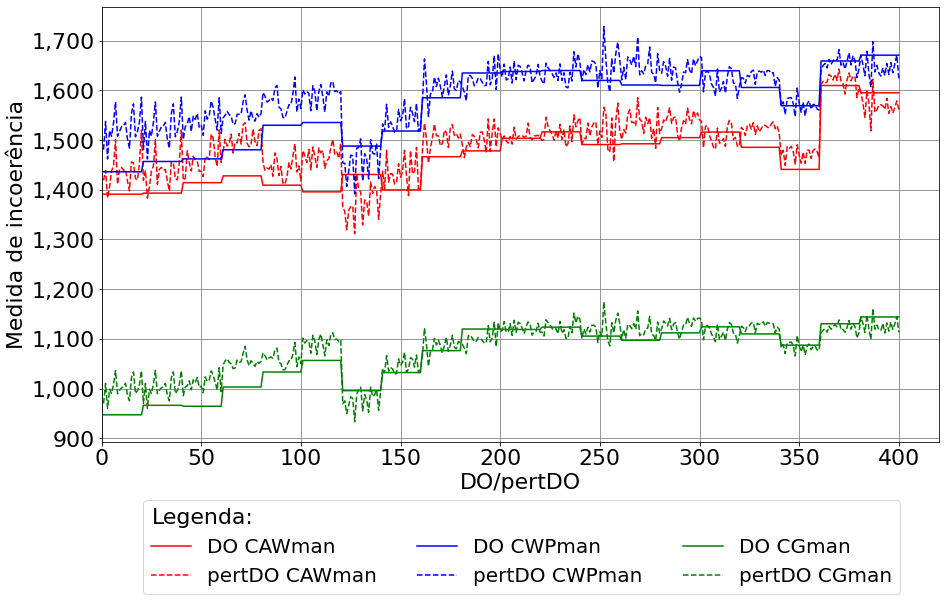

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW, 
                   lista_perturbado_CmanCAW, 
                   lista_original_CmanCWP, 
                   lista_perturbado_CmanCWP, 
                   lista_original_CmanCG, 
                   lista_perturbado_CmanCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCAW, lista_perturbado_CmanCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCWP, lista_perturbado_CmanCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CmanCG, lista_perturbado_CmanCG))

Diferença entre as equação CAW      : 14913.987888595582
Diferença entre as equação CWP      : 14971.50872938692
Diferença entre as equação CG       : 9483.19907903553


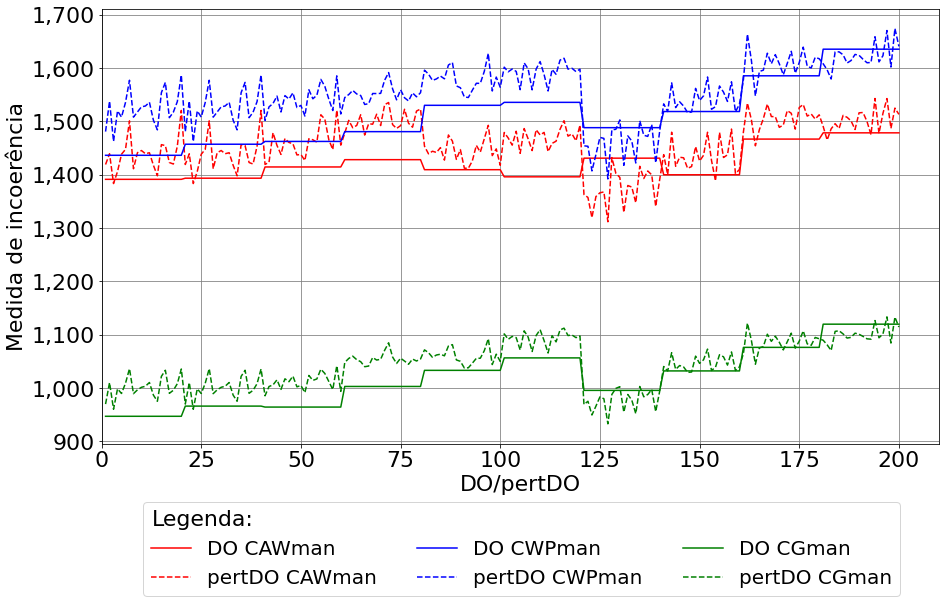

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:200], 
                   lista_perturbado_CmanCAW[0:200], 
                   lista_original_CmanCWP[0:200], 
                   lista_perturbado_CmanCWP[0:200], 
                   lista_original_CmanCG[0:200], 
                   lista_perturbado_CmanCG[0:200],
                   medida = medida)

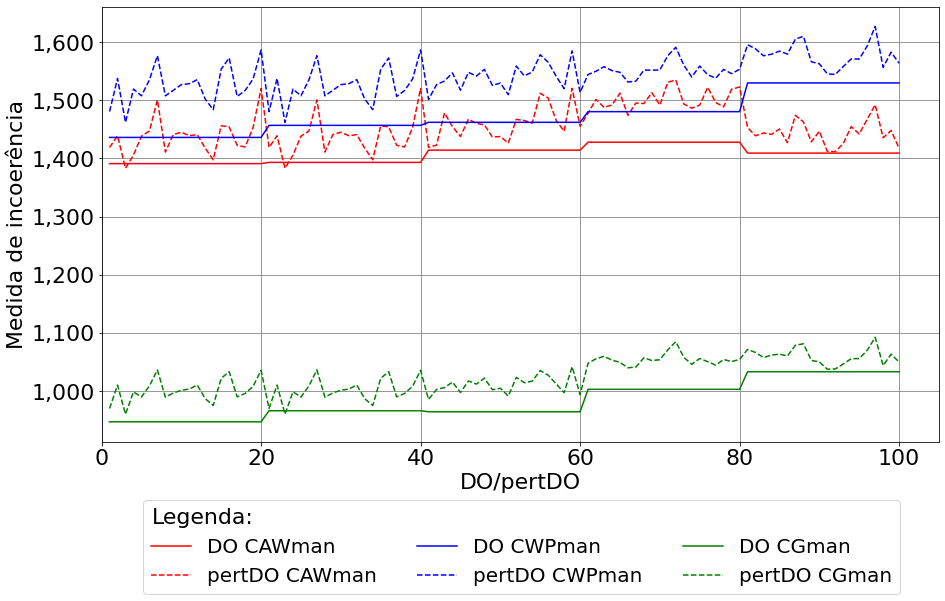

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:100], 
                   lista_perturbado_CmanCAW[0:100], 
                   lista_original_CmanCWP[0:100], 
                   lista_perturbado_CmanCWP[0:100], 
                   lista_original_CmanCG[0:100], 
                   lista_perturbado_CmanCG[0:100],
                   medida = medida)

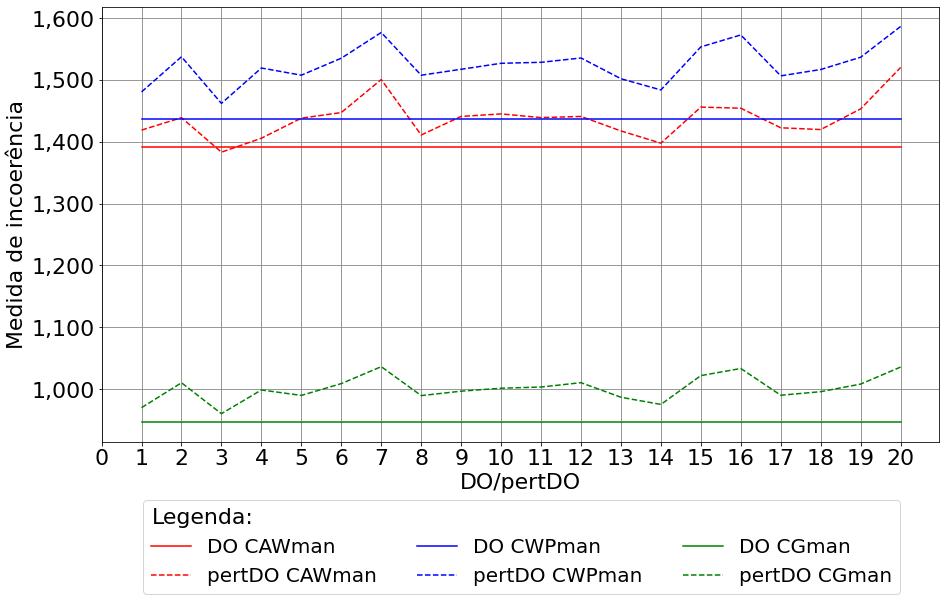

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:20], 
                   lista_perturbado_CmanCAW[0:20], 
                   lista_original_CmanCWP[0:20], 
                   lista_perturbado_CmanCWP[0:20], 
                   lista_original_CmanCG[0:20], 
                   lista_perturbado_CmanCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações

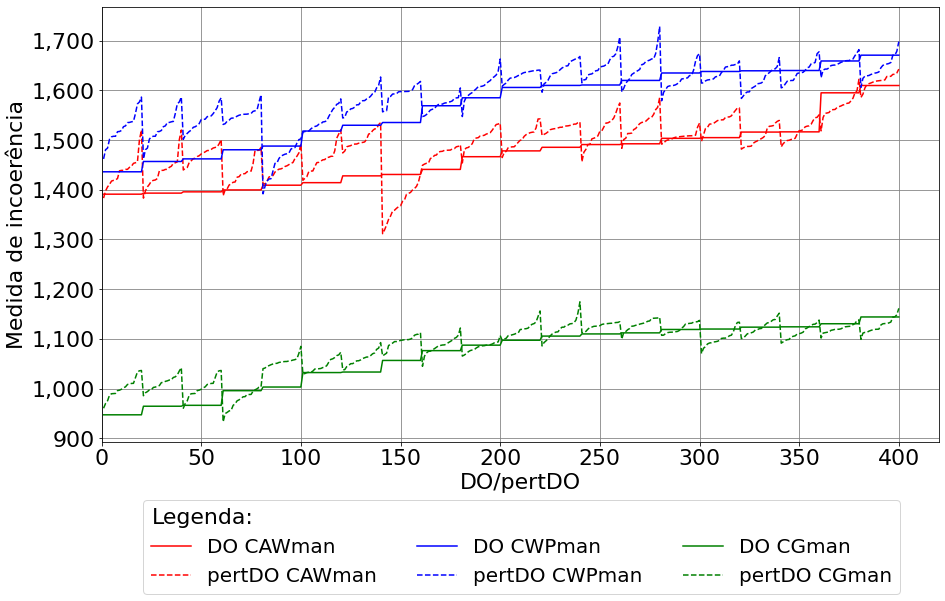

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW, 
                   lista_perturbado_ordenado_CmanCAW, 
                   lista_original_ordenado_CmanCWP, 
                   lista_perturbado_ordenado_CmanCWP, 
                   lista_original_ordenado_CmanCG, 
                   lista_perturbado_ordenado_CmanCG,
                   medida = medida)

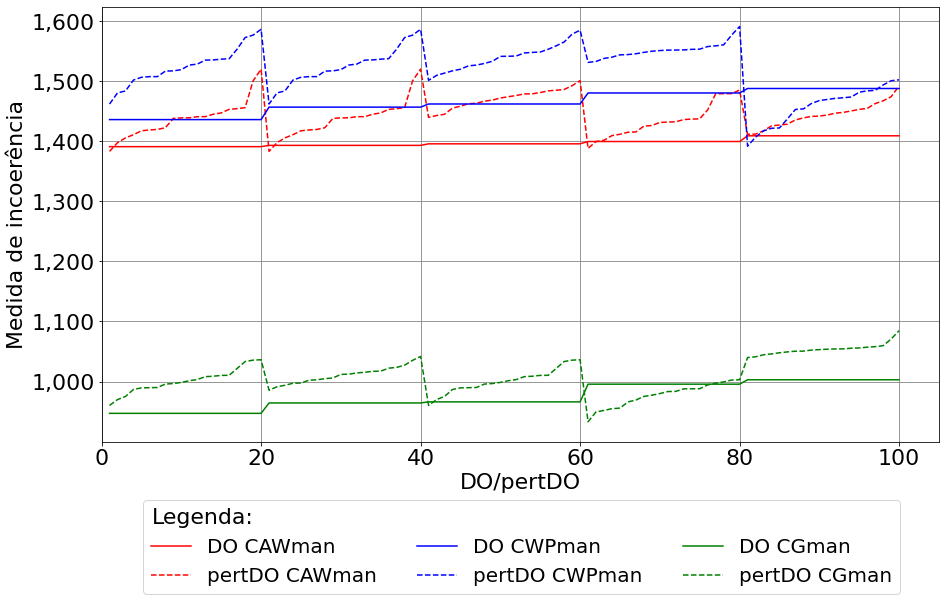

In [ ]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW[0:100], 
                   lista_perturbado_ordenado_CmanCAW[0:100], 
                   lista_original_ordenado_CmanCWP[0:100], 
                   lista_perturbado_ordenado_CmanCWP[0:100], 
                   lista_original_ordenado_CmanCG[0:100], 
                   lista_perturbado_ordenado_CmanCG[0:100],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

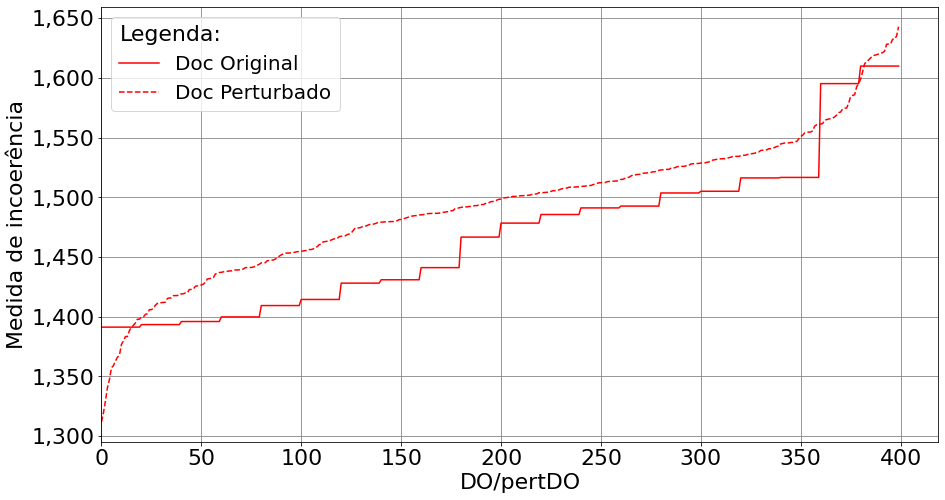

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_ordenado_CmanCAW, 
                    lista_perturbado_ordenado_CmanCAW,
                    'r',
                    medida = medida)

Sem ordem

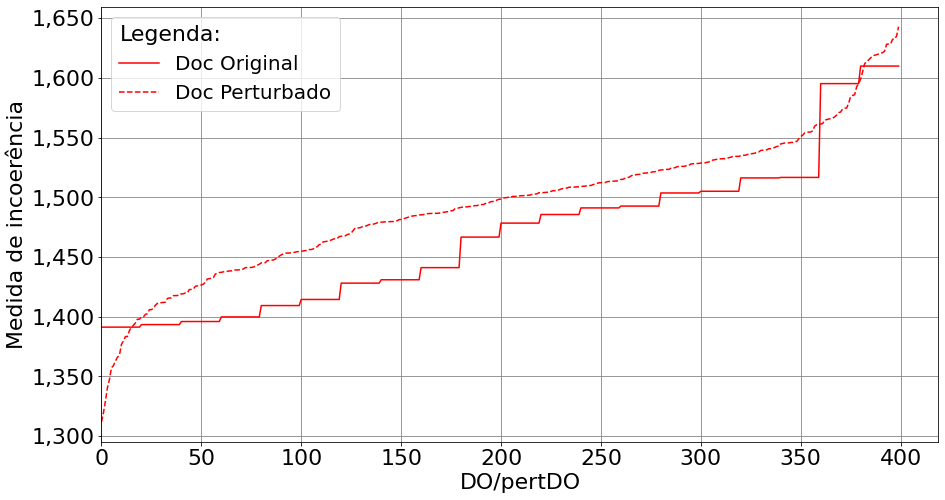

In [ ]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CmanCAW, 
                    lista_perturbado_CmanCAW,
                    'r',
                    medida = medida)

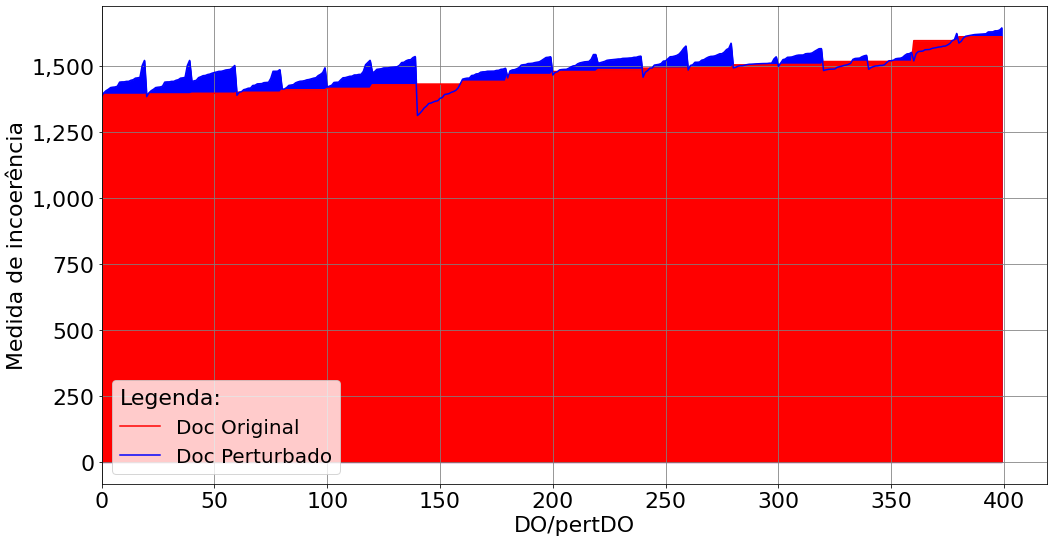

In [ ]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CmanCAW, 
                              lista_perturbado_ordenado_CmanCAW,
                              medida = 'man')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 14913.987888595582

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 136.49134545454535, 15, 'O que é uma fila e como desenfileirar um elemento nela?']
['19', 281.4727000000007, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['12', 329.0232181818176, 18, 'O que é uma pilha e como desempilhar um elemento nela?']
['16', 395.4963249999987, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['10', 504.4321100000027, 11, 'O que é uma fila e como enfileirar seu elemento?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 910.7915833333323, 6, 'Como empilhar elementos em uma pilha?']
['1', 945.3914500000037, 1, 'Como enfileirar elementos em uma fila?']
['7', 1167.5579499999985, 8, 'Como desempilhar elementos em uma pil

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 12536.848465514782

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.9876166666672361, 8, 'Como desempilhar elementos em uma pilha?']
['20', 30.984618181818632, 19, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['11', 101.7572909090909, 15, 'O que é uma fila e como desenfileirar um elemento nela?']
['16', 107.72825833333422, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['12', 173.40234545454382, 18, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 897.143416666667, 2, 'Como desenfileirar elementos em uma fila?']
['3', 910.79158333

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB CCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
  1 - Como criar e desempilhar elementos em uma estrutura de dados pilha ? [empilhar(>CAWman(DO)=1395,8643818182) -> criar(CAWman(pertDO)=1439,8768818182)] - VERB/VERB-1-0
  2 - Como capturar e desempilhar elementos em uma estrutura de dados pilha ? [empilhar(>CAWman(DO)=1395,8643818182) -> capturar(CAWman(pertDO)=1443,0415272727)] - VERB/VERB-1-0
  3 - Como organizar e desempilhar elementos em uma estrutura de dados pilha ? [empilhar(>CAWman(DO)=1395,8643818182) -> organizar(CAWman(pertDO)=1445,0421636364)] - VERB/VERB-1-0
  4 - Como separar e desempilhar elementos em uma estrutura de dados pilha ? [empilhar(>CAWman(DO)=1395,8643818182) -> separar(CAWman(pertDO)=1455,2695272727)] - VERB/VERB-1-0
  5 - Como cortar e desempilhar elementos em uma estrutura de dados pilha ? [empilhar(>CAWman(DO)=1395,8643818182) -> cortar(CAWman(pertDO)=1458

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: Como empilhar e desempilhar elementos em uma estrutura de dados pilha?
     SCONJ VERB CCONJ VERB NOUN ADP DET NOUN ADP NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;Como introduzir e desempilhar elementos em uma estrutura de dados pilha ?;empilhar;VERB;1395,8643818182;1535,4371948485;1056,4989058333;introduzir;VERB;1478,9834636364;1601,3778484848;1101,5059000000;0,1695999056;0;1
6_pert_1;Como juntar e desempilhar elementos em uma estrutura de dados pilha ?;empilhar;VERB;1395,8643818182;1535,4371948485;1056,4989058333;juntar;VERB;1468,6371818182;1592,6819181818;1091,3451666667;0,0757120922;0;1
6_pert_2;Como separar e desempilhar elementos em uma estrutura de dados pilha ?;empilhar;VERB;1395,8643818182;1535,4371948485;1056,4989058333;separar;VERB;1455,2695272727;1597,9337515152;1096,7685416667;0,0546390563;0;1
6

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 2377.139423080802

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 7.3324083333332055, 16, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['1', 7.915466666666589, 1, 'Como enfileirar elementos em uma fila?']
['14', 9.065854545454386, 14, 'O que é uma pilha e como empilhar um elemento nela?']
['2', 10.038233333333437, 2, 'Como desenfileirar elementos em uma fila?']
['8', 11.501011111110984, 4, 'Como desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 59.46413636363627, 13, 'O que é uma fila e como enfileirar um elemento nela?']
['12', 155.62087272727376, 18, 'O que

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
  1 - Como desempilhar elementos em uma cena ? [pilha(CAWman(DO)=1430,8433333333) -> cena(>CAWman(pertDO)=1311,6554666667)] - NOUN/NOUN-1-0
  2 - Como desempilhar elementos em uma construção ? [pilha(CAWman(DO)=1430,8433333333) -> construção(>CAWman(pertDO)=1319,3654666667)] - NOUN/NOUN-1-0
  3 - Como desempilhar elementos em uma estrutura ? [pilha(CAWman(DO)=1430,8433333333) -> estrutura(>CAWman(pertDO)=1329,2411833333)] - NOUN/NOUN-1-0
  4 - Como desempilhar elementos em uma escultura ? [pilha(CAWman(DO)=1430,8433333333) -> escultura(>CAWman(pertDO)=1340,4429833333)] - NOUN/NOUN-1-0
  5 - Como desempilhar elementos em uma montagem ? [pilha(CAWman(DO)=1430,8433333333) -> montagem(>CAWman(pertDO)=1347,2724166667)] - NOUN/NOUN-1-0
  6 - Como desempilhar elementos em uma pintura ? [pilha(CAWman(DO)=1430,8433333333) -> pintura(>CAWman(pertDO)=1357,1793833333)] - NOUN/NOUN-1-0
  7 - Como desempilha

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
7_pert_0;Como desempilhar elementos em uma imagem ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;imagem;NOUN;1362,7821666667;1454,0079428571;969,2194342857;0,0640644655;0;1
7_pert_1;Como desempilhar elementos em uma pintura ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;pintura;NOUN;1357,1793833333;1453,1446666667;975,2174057143;0,0422763191;0;1
7_pert_2;Como desempilhar elementos em uma construção ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;construção;NOUN;1319,3654666667;1406,9516714286;949,5048714286;0,0359632745;0;1
7_pert_3;Como desempilhar elementos em uma composição ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;composição;NOUN;1358,8895166667;1437,467

#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 14971.50872938692

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 198.5651500000008, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['18', 223.3852912087923, 9, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']
['11', 267.46609696970086, 16, 'O que é uma fila e como desenfileirar um elemento nela?']
['12', 339.0553696969703, 18, 'O que é uma pilha e como desempilhar um elemento nela?']
['8', 451.41415022222077, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 1162.0472196969579, 8, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?']
['2', 1356.201433333332, 2, 'Como desenfileirar elementos em uma fila?

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 12298.436927511022

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 33.31336190476122, 5, 'Como desempilhar elementos em uma pilha?']
['20', 35.11147121212139, 20, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['16', 42.666573846154506, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['19', 58.45526212121399, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['10', 102.40602545454271, 15, 'O que é uma fila e como enfileirar seu elemento?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 1162.0472196969579, 8, 'Como empilhar e desempilhar elementos em uma estrutura de

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como encontrar elementos em uma fila ? [enfileirar(>CWPman(DO)=1436,2210857143) -> encontrar(CWPman(pertDO)=1462,1526428571)] - VERB/VERB-1-0
  2 - Como colocar elementos em uma fila ? [enfileirar(>CWPman(DO)=1436,2210857143) -> colocar(CWPman(pertDO)=1480,6764857143)] - VERB/VERB-1-0
  3 - Como procurar elementos em uma fila ? [enfileirar(>CWPman(DO)=1436,2210857143) -> procurar(CWPman(pertDO)=1483,9232142857)] - VERB/VERB-1-0
  4 - Como incluir elementos em uma fila ? [enfileirar(>CWPman(DO)=1436,2210857143) -> incluir(CWPman(pertDO)=1502,0656190476)] - VERB/VERB-1-0
  5 - Como escolher elementos em uma fila ? [enfileirar(>CWPman(DO)=1436,2210857143) -> escolher(CWPman(pertDO)=1506,6994571429)] - VERB/VERB-1-0
  6 - Como conseguir elementos em uma fila ? [enfileirar(>CWPman(DO)=1436,2210857143) -> conseguir(CWPman(pertDO)=1507,7398571429)] - VERB/VERB-1-0
  7 - Como organizar elementos 

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;colocar;VERB;1418,9558000000;1480,6764857143;969,9350328571;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;identificar;VERB;1439,0682166667;1537,6276238095;1010,2467514286;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;encontrar;VERB;1383,2530166667;1462,1526428571;960,2382542857;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;adicionar;VERB;1405,8103166667;1519,4056

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 2673.071801875898

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 3.637568888888609, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['15', 13.68787717948726, 12, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['9', 44.9420145454535, 10, 'O que é uma pilha e como empilhar seu elemento?']
['13', 45.34632727272992, 14, 'O que é uma fila e como enfileirar um elemento nela?']
['18', 95.6516560439552, 9, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 210.8244196969722, 18, 'O que é uma pilha e como desempilha

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
  1 - Como desempilhar elementos em uma cena ? [pilha(CWPman(DO)=1487,9951476190) -> cena(>CWPman(pertDO)=1391,9212190476)] - NOUN/NOUN-1-0
  2 - Como desempilhar elementos em uma construção ? [pilha(CWPman(DO)=1487,9951476190) -> construção(>CWPman(pertDO)=1406,9516714286)] - NOUN/NOUN-1-0
  3 - Como desempilhar elementos em uma estrutura ? [pilha(CWPman(DO)=1487,9951476190) -> estrutura(>CWPman(pertDO)=1417,4203714286)] - NOUN/NOUN-1-0
  4 - Como desempilhar elementos em uma montagem ? [pilha(CWPman(DO)=1487,9951476190) -> montagem(>CWPman(pertDO)=1421,7725190476)] - NOUN/NOUN-1-0
  5 - Como desempilhar elementos em uma escultura ? [pilha(CWPman(DO)=1487,9951476190) -> escultura(>CWPman(pertDO)=1422,3092523810)] - NOUN/NOUN-1-0
  6 - Como desempilhar elementos em uma composição ? [pilha(CWPman(DO)=1487,9951476190) -> composição(>CWPman(pertDO)=1437,4671142857)] - NOUN/NOUN-1-0
  7 - Como dese

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
7_pert_0;Como desempilhar elementos em uma imagem ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;imagem;NOUN;1362,7821666667;1454,0079428571;969,2194342857;0,0640644655;0;1
7_pert_1;Como desempilhar elementos em uma pintura ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;pintura;NOUN;1357,1793833333;1453,1446666667;975,2174057143;0,0422763191;0;1
7_pert_2;Como desempilhar elementos em uma construção ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;construção;NOUN;1319,3654666667;1406,9516714286;949,5048714286;0,0359632745;0;1
7_pert_3;Como desempilhar elementos em uma composição ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;composição;NOUN;1358,8895166667;1437,467

#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 9483.19907903553

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 155.05906142857225, 10, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']
['11', 184.14870333333397, 15, 'O que é uma fila e como desenfileirar um elemento nela?']
['19', 215.67063333333158, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['12', 243.37214416666757, 17, 'O que é uma pilha e como desempilhar um elemento nela?']
['8', 290.5755240000017, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 710.8297814285731, 3, 'Como desenfileirar elementos em uma fila?']
['6', 754.6398441666663, 8, 'Como empilhar e desempilhar elementos em uma estrutura de dados pilha?'

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 7417.8430721645655

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 14.6057600000006, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['7', 19.640341428572015, 4, 'Como desempilhar elementos em uma pilha?']
['20', 21.86201249999931, 20, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['10', 33.73331090909119, 16, 'O que é uma fila e como enfileirar seu elemento?']
['16', 35.86494538461443, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 704.9166728571446, 3, 'Como desenfileirar elementos em uma fila?']
['6', 754.63984416

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como encontrar elementos em uma fila ? [enfileirar(>CGman(DO)=947,0550071429) -> encontrar(CGman(pertDO)=960,2382542857)] - VERB/VERB-1-0
  2 - Como colocar elementos em uma fila ? [enfileirar(>CGman(DO)=947,0550071429) -> colocar(CGman(pertDO)=969,9350328571)] - VERB/VERB-1-0
  3 - Como procurar elementos em uma fila ? [enfileirar(>CGman(DO)=947,0550071429) -> procurar(CGman(pertDO)=975,2213528571)] - VERB/VERB-1-0
  4 - Como incluir elementos em uma fila ? [enfileirar(>CGman(DO)=947,0550071429) -> incluir(CGman(pertDO)=986,7797842857)] - VERB/VERB-1-0
  5 - Como conseguir elementos em uma fila ? [enfileirar(>CGman(DO)=947,0550071429) -> conseguir(CGman(pertDO)=989,4714142857)] - VERB/VERB-1-0
  6 - Como organizar elementos em uma fila ? [enfileirar(>CGman(DO)=947,0550071429) -> organizar(CGman(pertDO)=989,7825528571)] - VERB/VERB-1-0
  7 - Como escolher elementos em uma fila ? [enfileir

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;colocar;VERB;1418,9558000000;1480,6764857143;969,9350328571;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;identificar;VERB;1439,0682166667;1537,6276238095;1010,2467514286;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;encontrar;VERB;1383,2530166667;1462,1526428571;960,2382542857;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;adicionar;VERB;1405,8103166667;1519,4056

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 2065.3560068709626

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.4935083333332386, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['8', 4.821676999999909, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['2', 5.913108571428552, 3, 'Como desenfileirar elementos em uma fila?']
['15', 12.705192307692187, 14, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['13', 47.67097333333368, 12, 'O que é uma fila e como enfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 201.06487333333098, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 2

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 10
DO: O que é uma fila e como enfileirar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
  1 - O que é uma fila e como definir seu elemento ? [enfileirar(CGman(DO)=1119,7046072727) -> definir(>CGman(pertDO)=1070,3167063636)] - VERB/VERB-1-0
  2 - O que é uma fila e como é seu elemento ? [enfileirar(CGman(DO)=1119,7046072727) -> é(>CGman(pertDO)=1080,9701145455)] - VERB/AUX-0-0
  3 - O que é uma fila e como seria seu elemento ? [enfileirar(CGman(DO)=1119,7046072727) -> seria(>CGman(pertDO)=1084,3310936364)] - VERB/AUX-0-0
  4 - O que é uma fila e como identificar seu elemento ? [enfileirar(CGman(DO)=1119,7046072727) -> identificar(>CGman(pertDO)=1089,6047636364)] - VERB/VERB-1-0
  5 - O que é uma fila e como encontrar seu elemento ? [enfileirar(CGman(DO)=1119,7046072727) -> encontrar(>CGman(pertDO)=1091,5776090909)] - VERB/VERB-1-0
  6 - O que é uma fila e como distinguir seu elemento ? [enfileirar(CGman(DO)=1119,7046072727) -> distinguir(>CGman(pertDO)=

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 10
DO: O que é uma fila e como enfileirar seu elemento?
     PRON PRON AUX DET NOUN CCONJ ADV VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
10_pert_0;O que é uma fila e como identificar seu elemento ?;enfileirar;VERB;1478,3085300000;1635,1035927273;1119,7046072727;identificar;VERB;1490,3930600000;1607,7591618182;1089,6047636364;0,4559765458;0;1
10_pert_1;O que é uma fila e como é seu elemento ?;enfileirar;VERB;1478,3085300000;1635,1035927273;1119,7046072727;é;AUX;1464,8662500000;1596,3966345455;1080,9701145455;0,0366640650;0;0
10_pert_2;O que é uma fila e como definir seu elemento ?;enfileirar;VERB;1478,3085300000;1635,1035927273;1119,7046072727;definir;VERB;1485,7917200000;1579,2218454545;1070,3167063636;0,0358846597;0;1
10_pert_3;O que é uma fila e como localizar seu elemento ?;enfileirar;VERB;1478,3085300000;1635,10359

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 2065.3560068709626

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 30.517645454545345, 15, 'O que é uma fila e como desenfileirar um elemento nela?']
['19', 32.9794090909088, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['12', 34.282572727272736, 18, 'O que é uma pilha e como desempilhar um elemento nela?']
['16', 34.359408333332794, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['18', 49.52806923076946, 9, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 106.34504999999967, 6, 'Como empilhar elementos em uma pilha?']
['4', 107.0933749999997, 7, 'Como empilhar 

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 2065.3560068709626

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 0.9876166666672361, 8, 'Como desempilhar elementos em uma pilha?']
['16', 23.495866666666643, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['20', 27.17331818181833, 19, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']
['11', 30.517645454545345, 15, 'O que é uma fila e como desenfileirar um elemento nela?']
['19', 32.9794090909088, 20, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 105.19558181818184, 3, 'Como empilhar e desempilhar elementos em uma estrutura de dados

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como encontrar elementos em uma fila ? [enfileirar(CAWman(DO)=1391,1684833333) -> encontrar(>CAWman(pertDO)=1383,2530166667)] - VERB/VERB-1-0
  2 - Como procurar elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> procurar(CAWman(pertDO)=1397,8069333333)] - VERB/VERB-1-0
  3 - Como adicionar elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> adicionar(CAWman(pertDO)=1405,8103166667)] - VERB/VERB-1-0
  4 - Como conseguir elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> conseguir(CAWman(pertDO)=1411,0486666667)] - VERB/VERB-1-0
  5 - Como incluir elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> incluir(CAWman(pertDO)=1417,5870333333)] - VERB/VERB-1-0
  6 - Como colocar elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> colocar(CAWman(pertDO)=1418,9558000000)] - VERB/VERB-1-0
  7 - Como obter elementos em

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;colocar;VERB;1418,9558000000;1480,6764857143;969,9350328571;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;identificar;VERB;1439,0682166667;1537,6276238095;1010,2467514286;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;encontrar;VERB;1383,2530166667;1462,1526428571;960,2382542857;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;adicionar;VERB;1405,8103166667;1519,4056

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 2065.3560068709626

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 7.3324083333332055, 16, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['1', 7.915466666666589, 1, 'Como enfileirar elementos em uma fila?']
['14', 9.065854545454386, 14, 'O que é uma pilha e como empilhar um elemento nela?']
['2', 10.038233333333437, 2, 'Como desenfileirar elementos em uma fila?']
['8', 11.501011111110984, 4, 'Como desempilhar elementos em uma estrutura de dados pilha?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 30.1996363636365, 18, 'O que é uma pilha e como desempilhar um elemento nela?']
['13', 34.34503636363638, 13, 'O que é uma fi

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
  1 - Como desempilhar elementos em uma cena ? [pilha(CAWman(DO)=1430,8433333333) -> cena(>CAWman(pertDO)=1311,6554666667)] - NOUN/NOUN-1-0
  2 - Como desempilhar elementos em uma construção ? [pilha(CAWman(DO)=1430,8433333333) -> construção(>CAWman(pertDO)=1319,3654666667)] - NOUN/NOUN-1-0
  3 - Como desempilhar elementos em uma estrutura ? [pilha(CAWman(DO)=1430,8433333333) -> estrutura(>CAWman(pertDO)=1329,2411833333)] - NOUN/NOUN-1-0
  4 - Como desempilhar elementos em uma escultura ? [pilha(CAWman(DO)=1430,8433333333) -> escultura(>CAWman(pertDO)=1340,4429833333)] - NOUN/NOUN-1-0
  5 - Como desempilhar elementos em uma montagem ? [pilha(CAWman(DO)=1430,8433333333) -> montagem(>CAWman(pertDO)=1347,2724166667)] - NOUN/NOUN-1-0
  6 - Como desempilhar elementos em uma pintura ? [pilha(CAWman(DO)=1430,8433333333) -> pintura(>CAWman(pertDO)=1357,1793833333)] - NOUN/NOUN-1-0
  7 - Como desempilha

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
7_pert_0;Como desempilhar elementos em uma imagem ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;imagem;NOUN;1362,7821666667;1454,0079428571;969,2194342857;0,0640644655;0;1
7_pert_1;Como desempilhar elementos em uma pintura ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;pintura;NOUN;1357,1793833333;1453,1446666667;975,2174057143;0,0422763191;0;1
7_pert_2;Como desempilhar elementos em uma construção ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;construção;NOUN;1319,3654666667;1406,9516714286;949,5048714286;0,0359632745;0;1
7_pert_3;Como desempilhar elementos em uma composição ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;composição;NOUN;1358,8895166667;1437,467

#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 2065.3560068709626

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 23.32506212121234, 16, 'O que é uma fila e como desenfileirar um elemento nela?']
['19', 33.57430757575753, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['17', 34.945834395603924, 11, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['18', 35.82740000000035, 9, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']
['12', 37.763412121211786, 18, 'O que é uma pilha e como desempilhar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 108.59905757575666, 14, 'O que é uma fila e como enfileirar um elemento nela?']
['4', 1

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 2065.3560068709626

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 14.489638095237979, 5, 'Como desempilhar elementos em uma pilha?']
['11', 21.329913636363926, 16, 'O que é uma fila e como desenfileirar um elemento nela?']
['19', 22.85002727272672, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 26.54794282051307, 17, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['20', 27.276490909090853, 20, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 108.59905757575666, 14, 'O que é uma fila e como enfileirar um elemento nela?']
['4',

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como encontrar elementos em uma fila ? [enfileirar(CAWman(DO)=1391,1684833333) -> encontrar(>CAWman(pertDO)=1383,2530166667)] - VERB/VERB-1-0
  2 - Como procurar elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> procurar(CAWman(pertDO)=1397,8069333333)] - VERB/VERB-1-0
  3 - Como adicionar elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> adicionar(CAWman(pertDO)=1405,8103166667)] - VERB/VERB-1-0
  4 - Como conseguir elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> conseguir(CAWman(pertDO)=1411,0486666667)] - VERB/VERB-1-0
  5 - Como incluir elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> incluir(CAWman(pertDO)=1417,5870333333)] - VERB/VERB-1-0
  6 - Como colocar elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> colocar(CAWman(pertDO)=1418,9558000000)] - VERB/VERB-1-0
  7 - Como obter elementos em

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;colocar;VERB;1418,9558000000;1480,6764857143;969,9350328571;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;identificar;VERB;1439,0682166667;1537,6276238095;1010,2467514286;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;encontrar;VERB;1383,2530166667;1462,1526428571;960,2382542857;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;adicionar;VERB;1405,8103166667;1519,4056

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 2065.3560068709626

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 2.2081688888888493, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['15', 13.68787717948726, 12, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']
['18', 21.64860439560357, 9, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']
['13', 23.035460606060724, 14, 'O que é uma fila e como enfileirar um elemento nela?']
['11', 23.32506212121234, 16, 'O que é uma fila e como desenfileirar um elemento nela?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 37.782052727272, 10, 'O que é uma pilha e como empilhar seu

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
  1 - Como desempilhar elementos em uma cena ? [pilha(CAWman(DO)=1430,8433333333) -> cena(>CAWman(pertDO)=1311,6554666667)] - NOUN/NOUN-1-0
  2 - Como desempilhar elementos em uma construção ? [pilha(CAWman(DO)=1430,8433333333) -> construção(>CAWman(pertDO)=1319,3654666667)] - NOUN/NOUN-1-0
  3 - Como desempilhar elementos em uma estrutura ? [pilha(CAWman(DO)=1430,8433333333) -> estrutura(>CAWman(pertDO)=1329,2411833333)] - NOUN/NOUN-1-0
  4 - Como desempilhar elementos em uma escultura ? [pilha(CAWman(DO)=1430,8433333333) -> escultura(>CAWman(pertDO)=1340,4429833333)] - NOUN/NOUN-1-0
  5 - Como desempilhar elementos em uma montagem ? [pilha(CAWman(DO)=1430,8433333333) -> montagem(>CAWman(pertDO)=1347,2724166667)] - NOUN/NOUN-1-0
  6 - Como desempilhar elementos em uma pintura ? [pilha(CAWman(DO)=1430,8433333333) -> pintura(>CAWman(pertDO)=1357,1793833333)] - NOUN/NOUN-1-0
  7 - Como desempilha

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
7_pert_0;Como desempilhar elementos em uma imagem ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;imagem;NOUN;1362,7821666667;1454,0079428571;969,2194342857;0,0640644655;0;1
7_pert_1;Como desempilhar elementos em uma pintura ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;pintura;NOUN;1357,1793833333;1453,1446666667;975,2174057143;0,0422763191;0;1
7_pert_2;Como desempilhar elementos em uma construção ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;construção;NOUN;1319,3654666667;1406,9516714286;949,5048714286;0,0359632745;0;1
7_pert_3;Como desempilhar elementos em uma composição ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;composição;NOUN;1358,8895166667;1437,467

#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 2065.3560068709626

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 18.32501666666667, 15, 'O que é uma fila e como desenfileirar um elemento nela?']
['18', 22.010671428571413, 10, 'Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila?']
['17', 24.522835714285975, 13, 'Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?']
['12', 28.13482833333319, 17, 'O que é uma pilha e como desempilhar um elemento nela?']
['19', 28.75716250000005, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 68.95970083333327, 12, 'O que é uma fila e como enfileirar um elemento nela?']
['2', 70.

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 2065.3560068709626

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['7', 7.287388571428437, 4, 'Como desempilhar elementos em uma pilha?']
['19', 7.794558333333271, 19, 'Em uma pilha a operação de empilhar ocorre em qual extremidade?']
['16', 13.600763846153768, 18, 'O que é uma fila e como enfileirar e desenfileirar seus elementos?']
['10', 13.736165454545699, 16, 'O que é uma fila e como enfileirar seu elemento?']
['20', 17.344688333333124, 20, 'Em uma fila a operação de enfileirar ocorre em qual extremidade?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 68.95970083333327, 12, 'O que é uma fila e como enfileirar um elemento nela?']
['2', 70.147422

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
  1 - Como encontrar elementos em uma fila ? [enfileirar(CAWman(DO)=1391,1684833333) -> encontrar(>CAWman(pertDO)=1383,2530166667)] - VERB/VERB-1-0
  2 - Como procurar elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> procurar(CAWman(pertDO)=1397,8069333333)] - VERB/VERB-1-0
  3 - Como adicionar elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> adicionar(CAWman(pertDO)=1405,8103166667)] - VERB/VERB-1-0
  4 - Como conseguir elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> conseguir(CAWman(pertDO)=1411,0486666667)] - VERB/VERB-1-0
  5 - Como incluir elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> incluir(CAWman(pertDO)=1417,5870333333)] - VERB/VERB-1-0
  6 - Como colocar elementos em uma fila ? [enfileirar(>CAWman(DO)=1391,1684833333) -> colocar(CAWman(pertDO)=1418,9558000000)] - VERB/VERB-1-0
  7 - Como obter elementos em

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: Como enfileirar elementos em uma fila?
     SCONJ VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;Como colocar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;colocar;VERB;1418,9558000000;1480,6764857143;969,9350328571;0,1963338256;0;1
1_pert_1;Como identificar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;identificar;VERB;1439,0682166667;1537,6276238095;1010,2467514286;0,0832660347;0;1
1_pert_2;Como encontrar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;encontrar;VERB;1383,2530166667;1462,1526428571;960,2382542857;0,0771737620;0;1
1_pert_3;Como adicionar elementos em uma fila ?;enfileirar;VERB;1391,1684833333;1436,2210857143;947,0550071429;adicionar;VERB;1405,8103166667;1519,4056

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 2065.3560068709626

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.4935083333332386, 11, 'O que é uma pilha e como empilhar um elemento nela?']
['8', 2.7880639999998493, 6, 'Como desempilhar elementos em uma estrutura de dados pilha?']
['2', 5.913108571428552, 3, 'Como desenfileirar elementos em uma fila?']
['11', 11.802353333333258, 15, 'O que é uma fila e como desenfileirar um elemento nela?']
['15', 12.705192307692187, 14, 'O que é uma pilha e como empilhar e desempilhar seus elementos?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['9', 31.579466363636357, 9, 'O que é uma pilha e como empilhar seu elemento?']
['16', 32.90995230769249, 18, 'O q

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
  1 - Como desempilhar elementos em uma cena ? [pilha(CAWman(DO)=1430,8433333333) -> cena(>CAWman(pertDO)=1311,6554666667)] - NOUN/NOUN-1-0
  2 - Como desempilhar elementos em uma construção ? [pilha(CAWman(DO)=1430,8433333333) -> construção(>CAWman(pertDO)=1319,3654666667)] - NOUN/NOUN-1-0
  3 - Como desempilhar elementos em uma estrutura ? [pilha(CAWman(DO)=1430,8433333333) -> estrutura(>CAWman(pertDO)=1329,2411833333)] - NOUN/NOUN-1-0
  4 - Como desempilhar elementos em uma escultura ? [pilha(CAWman(DO)=1430,8433333333) -> escultura(>CAWman(pertDO)=1340,4429833333)] - NOUN/NOUN-1-0
  5 - Como desempilhar elementos em uma montagem ? [pilha(CAWman(DO)=1430,8433333333) -> montagem(>CAWman(pertDO)=1347,2724166667)] - NOUN/NOUN-1-0
  6 - Como desempilhar elementos em uma pintura ? [pilha(CAWman(DO)=1430,8433333333) -> pintura(>CAWman(pertDO)=1357,1793833333)] - NOUN/NOUN-1-0
  7 - Como desempilha

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 7
DO: Como desempilhar elementos em uma pilha?
     ADP NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
7_pert_0;Como desempilhar elementos em uma imagem ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;imagem;NOUN;1362,7821666667;1454,0079428571;969,2194342857;0,0640644655;0;1
7_pert_1;Como desempilhar elementos em uma pintura ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;pintura;NOUN;1357,1793833333;1453,1446666667;975,2174057143;0,0422763191;0;1
7_pert_2;Como desempilhar elementos em uma construção ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;construção;NOUN;1319,3654666667;1406,9516714286;949,5048714286;0,0359632745;0;1
7_pert_3;Como desempilhar elementos em uma composição ?;pilha;NOUN;1430,8433333333;1487,9951476190;995,6269685714;composição;NOUN;1358,8895166667;1437,467

# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:01:14 (h:mm:ss)
